In [1]:
!pip install bettermdptools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.5/335.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 14.2 MB/s eta 0:00:00
  Created wheel for bettermdptools: filename=bettermdptools-0.6.0-py3-none-any.whl size=81944 sha256=72b3d4255e71c8eec8ebfa4776c5507ed07f4059e267c7dbea2605b8cab9c332
  Stored in directory: /root/.cache/pip/wheels/38/64/e8/5f38c9e70d6cae667987f862ba3e5b4e3e78e8328b46158774
Successfully built bettermdptools


### Part 1: Implementing the Gambler's Problem Environment with 500 States

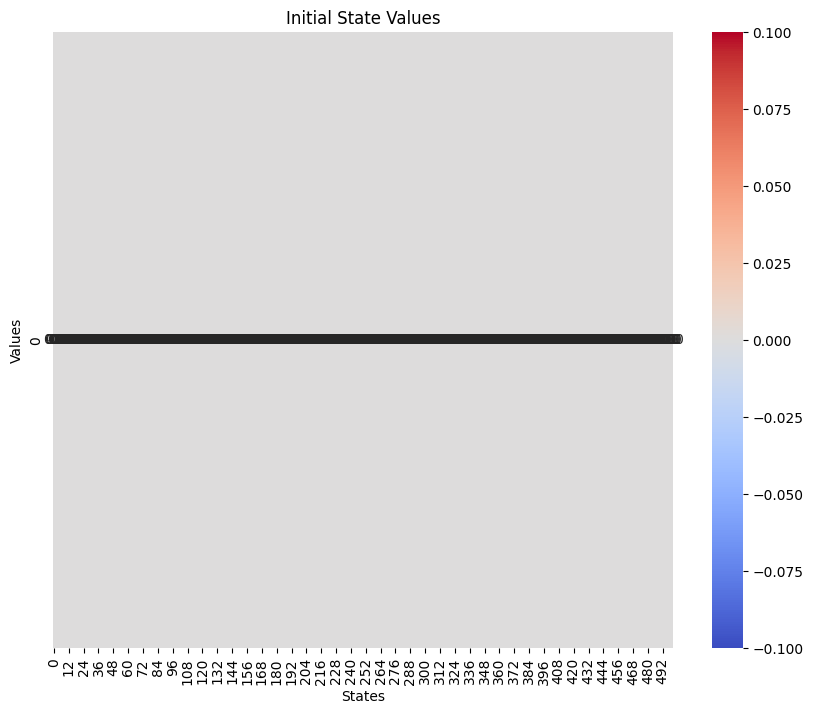

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bettermdptools.algorithms.planner import Planner
import gym

# Custom Gambler's Problem environment
class GamblersProblemEnv(gym.Env):
    def __init__(self, max_capital=500, win_prob=0.5):
        super(GamblersProblemEnv, self).__init__()
        self.max_capital = max_capital
        self.win_prob = win_prob
        self.action_space = gym.spaces.Discrete(max_capital+1)
        self.observation_space = gym.spaces.Discrete(max_capital+1)
        self.state = 0  # Initial state
        self.P = self._generate_P()



    def _generate_P(self):
        P = {}
        for state in range(self.max_capital + 1):
            P[state] = {}
            for action in range(self.max_capital + 1):
                P[state][action] = []
                if action <= state and action <= self.max_capital - state:
                    win_state = state + action
                    lose_state = state - action
                    # win = (self.win_prob, win_state, int(win_state == self.max_capital), win_state == 0 or win_state == self.max_capital)
                    win = (self.win_prob, win_state, int(win_state == self.max_capital), win_state == self.max_capital)
                    lose = (1 - self.win_prob, lose_state, 0, lose_state == 0)
                    P[state][action] = [win, lose]
                else:
                    # Invalid action, remains in the same state without any reward
                    P[state][action].append((1.0, state, 0, state == 0 or state == self.max_capital))
        return P

    def step(self, action):
        # raise NotImplementedError
        # assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action)
        outcome = np.random.binomial(1, self.win_prob)  # 1 for win, 0 for loss
        if outcome:
            self.state = min(self.state + action, self.max_capital)
        else:
            self.state = max(self.state - action, 0)
        done = self.state == 0 or self.state == self.max_capital
        reward = 1 if self.state == self.max_capital else 0
        return self.state, reward, done, {}
        # return self.state, reward, done, {}, {}  # Added an extra empty dictionary

    def reset(self):
        self.state = 0
        return self.state
        # return self.state, {}  # Modified to return a tuple

    def render(self, mode='human', close=False):
        raise NotImplementedError

# Initialize environment
env = GamblersProblemEnv()

# Display initial state values using a heatmap
initial_values = np.zeros(env.observation_space.n)
plt.figure(figsize=(10, 8))
sns.heatmap(initial_values.reshape(1, -1), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Initial State Values")
plt.xlabel("States")
plt.ylabel("Values")
plt.show()

<ipython-input-3-629ce3d45361>:46: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(policy, use_line_collection=True)


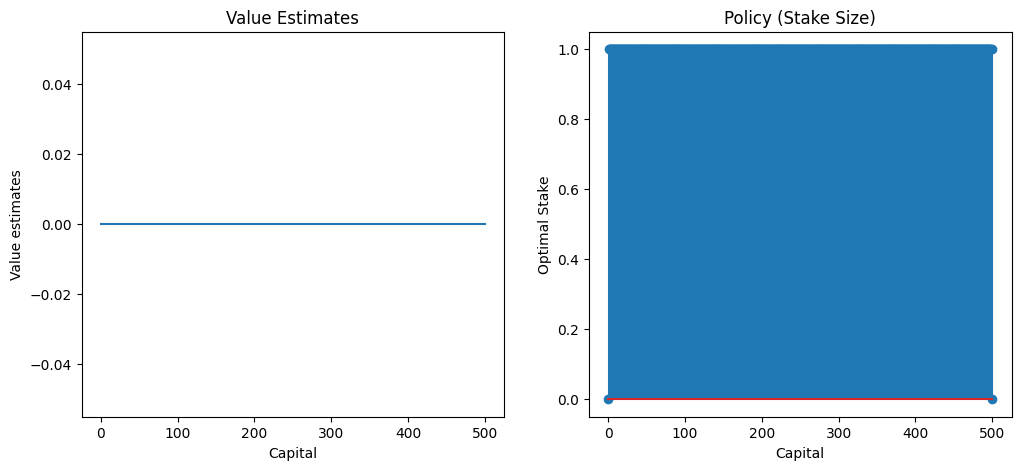

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gambler_problem(p_win, goal=500):
    values = np.zeros(goal + 1)
    policy = np.zeros(goal + 1)
    theta = 1e-9
    gamma = 1  # Assume a discount factor of 1 for simplicity

    while True:
        delta = 0
        for capital in range(1, goal):
            old_value = values[capital]
            actions = range(1, min(capital, goal - capital) + 1)
            action_values = [p_win * (gamma * values[capital + bet]) + (1 - p_win) * (gamma * values[capital - bet])
                             for bet in actions]
            values[capital] = max(action_values)
            delta = max(delta, abs(values[capital] - old_value))
        if delta < theta:
            break

    for capital in range(1, goal):
        actions = range(1, min(capital, goal - capital) + 1)
        action_values = [p_win * (gamma * values[capital + bet]) + (1 - p_win) * (gamma * values[capital - bet])
                         for bet in actions]
        policy[capital] = actions[np.argmax(action_values)]

    return values, policy

# Parameters
p_win = 0.4
goal = 500

# Get values and policy
values, policy = gambler_problem(p_win, goal)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(values)
plt.title('Value Estimates')
plt.xlabel('Capital')
plt.ylabel('Value estimates')

plt.subplot(1, 2, 2)
plt.stem(policy, use_line_collection=True)
plt.title('Policy (Stake Size)')
plt.xlabel('Capital')
plt.ylabel('Optimal Stake')
plt.show()


### Part 2: Running Policy Iteration on the Gambler's Problem

runtime = 4.38 seconds


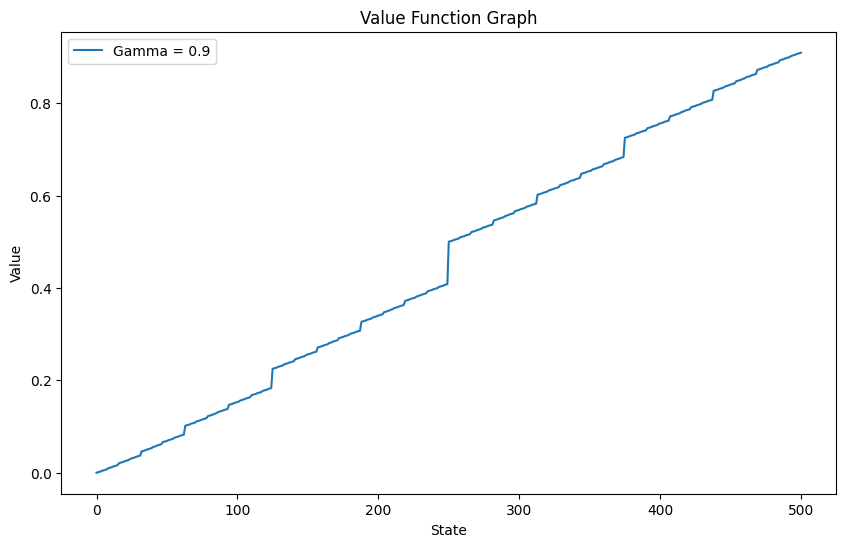

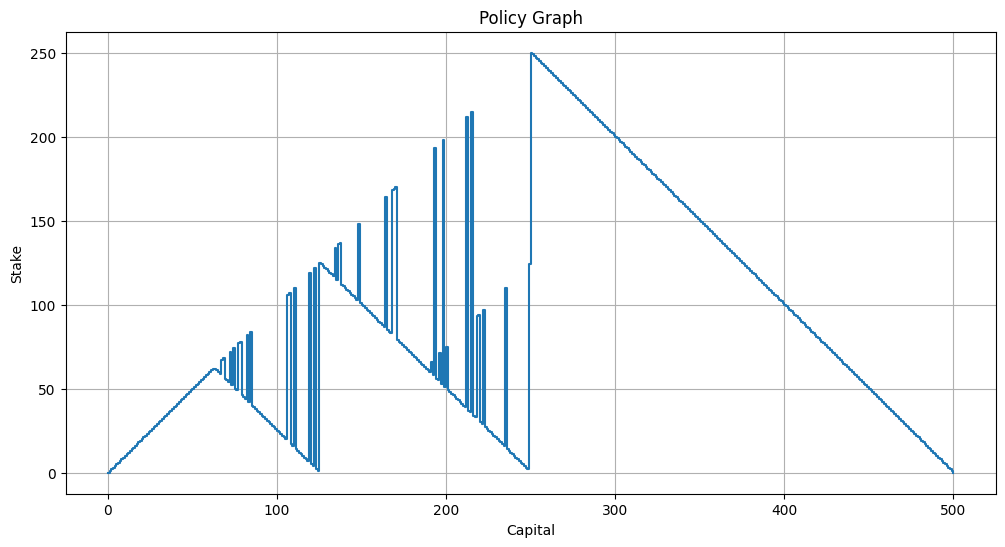

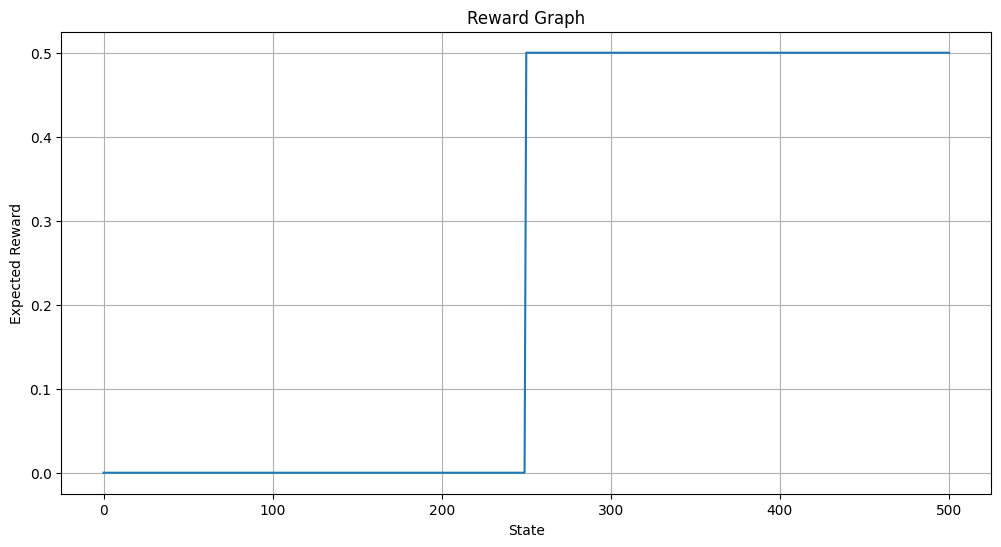

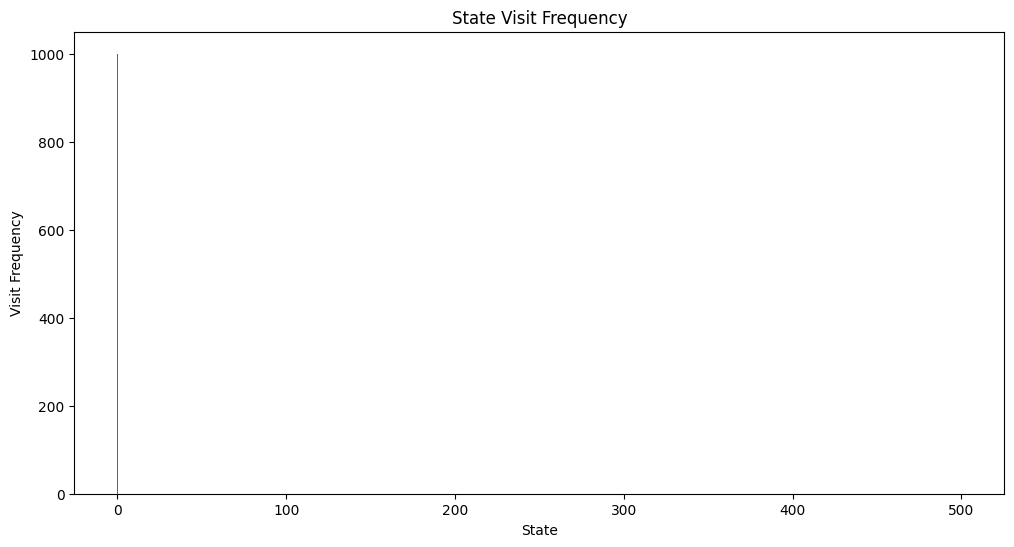

runtime = 6.48 seconds


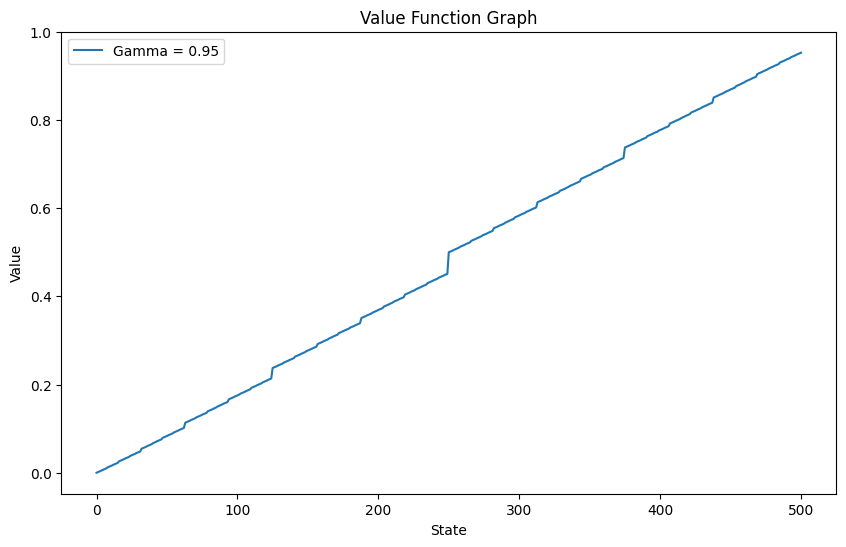

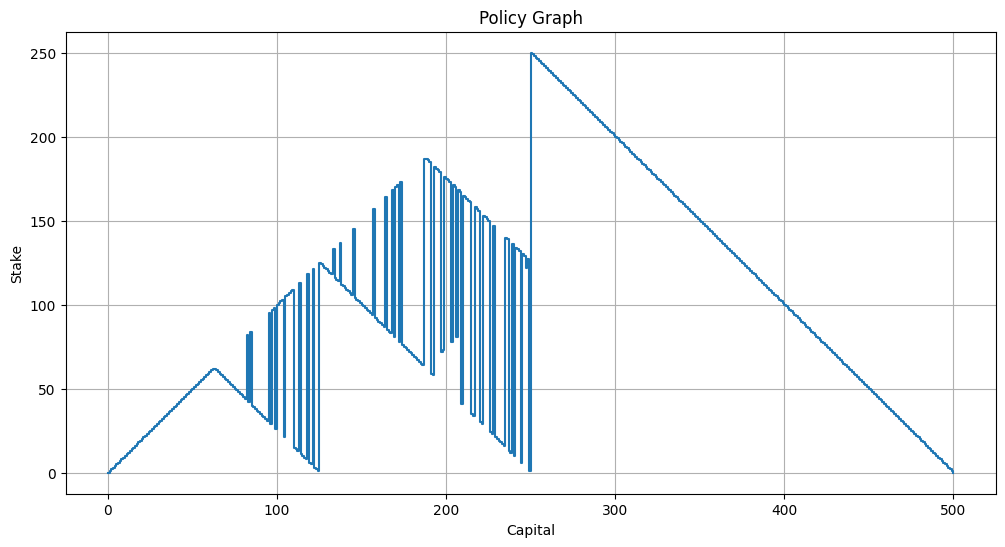

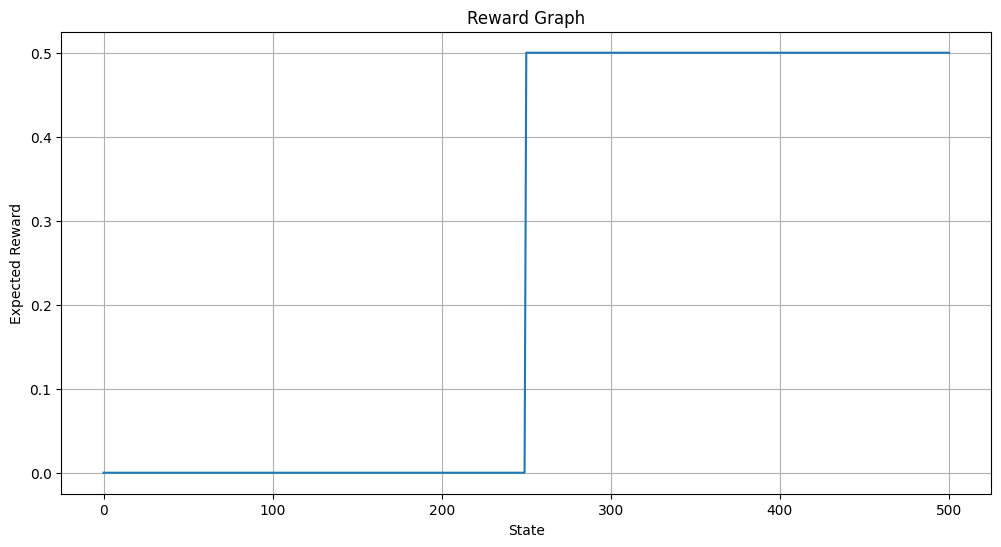

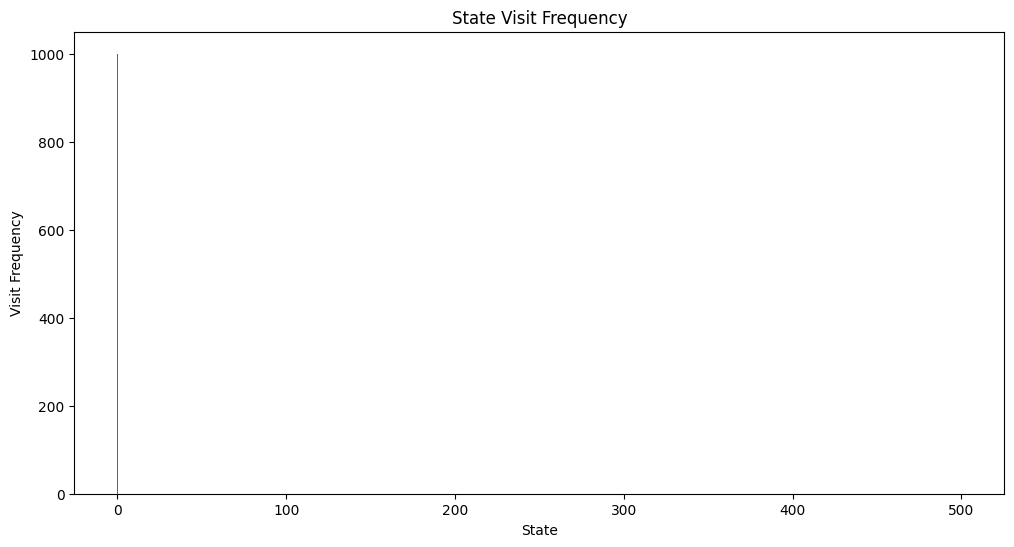

runtime = 4.91 seconds


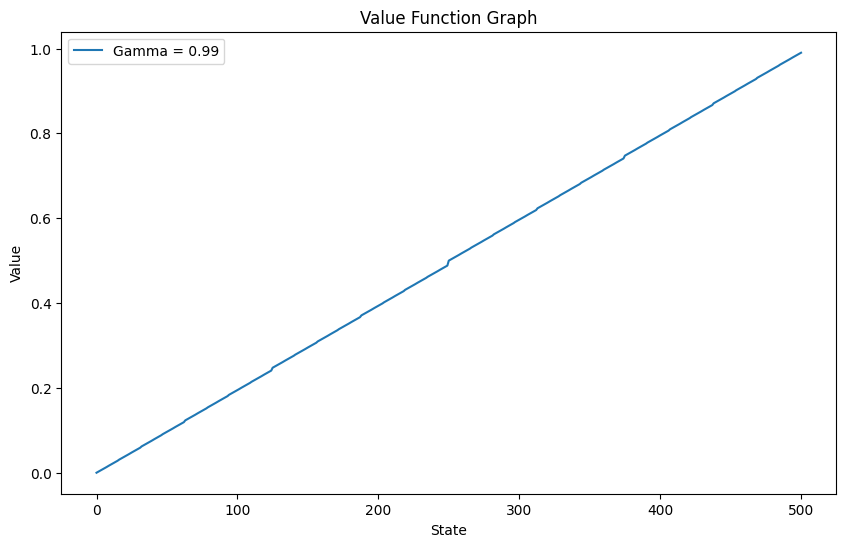

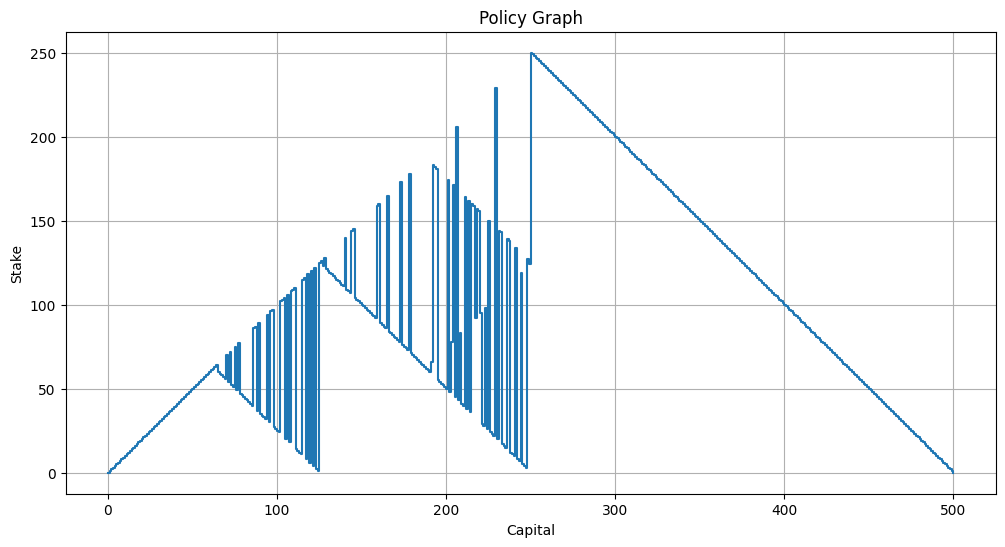

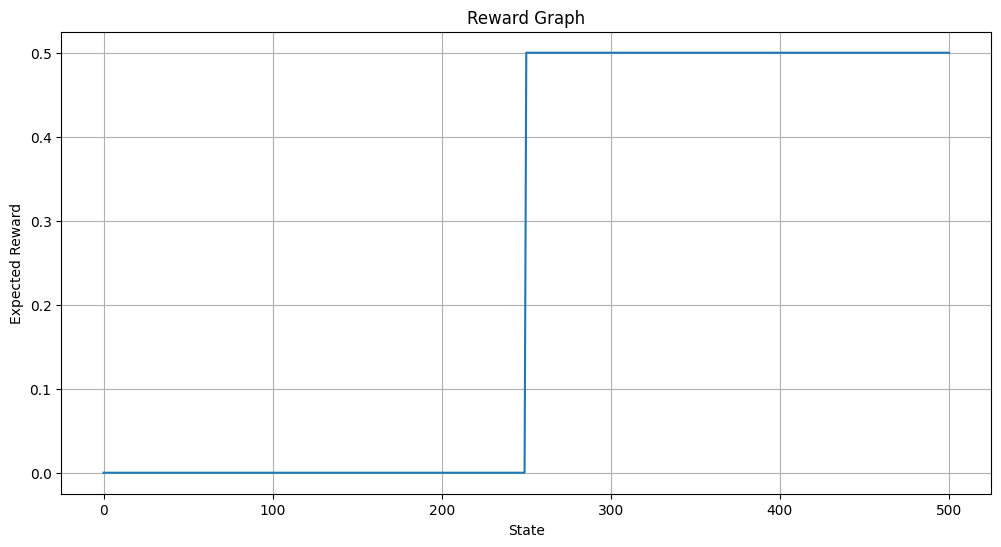

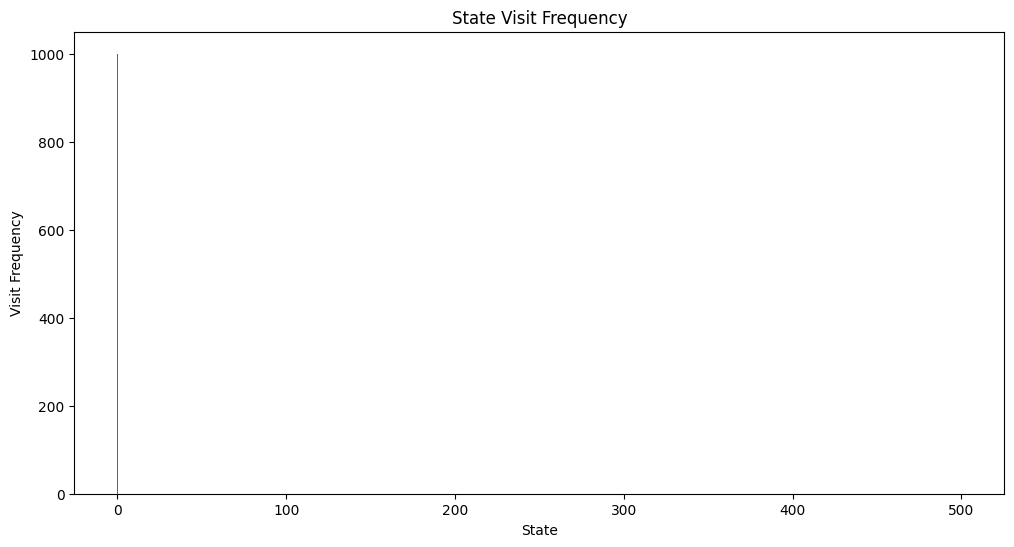

runtime = 13.04 seconds


/usr/local/lib/python3.10/dist-packages/bettermdptools/algorithms/planner.py:126: UserWarning: Max iterations reached before convergence.  Check n_iters.
  warnings.warn("Max iterations reached before convergence.  Check n_iters.")


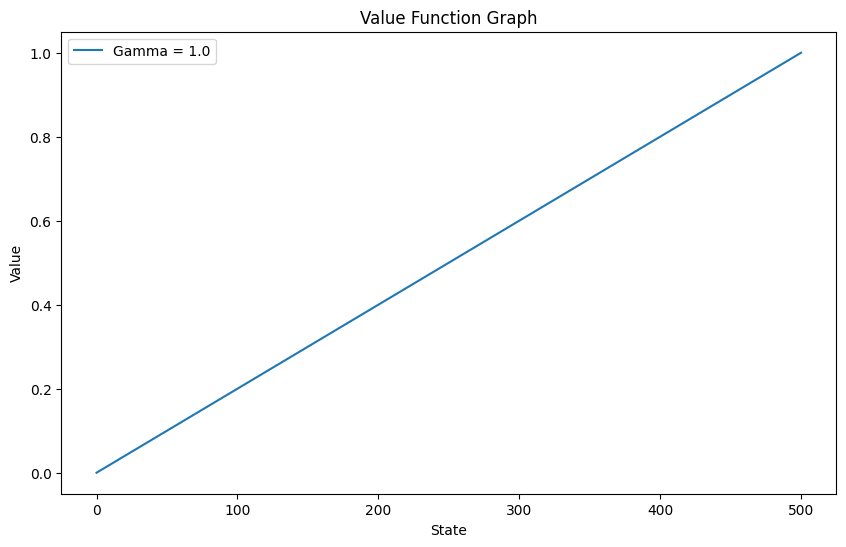

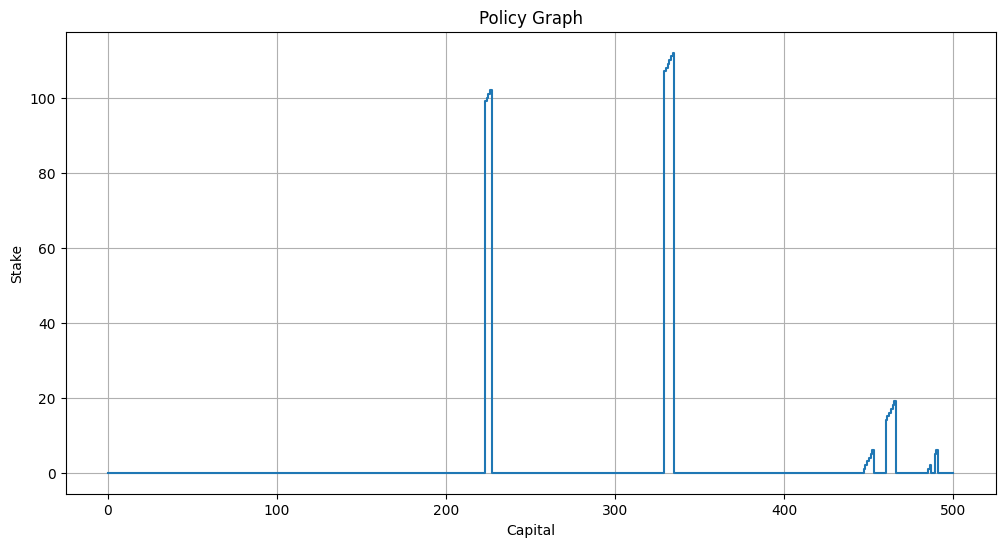

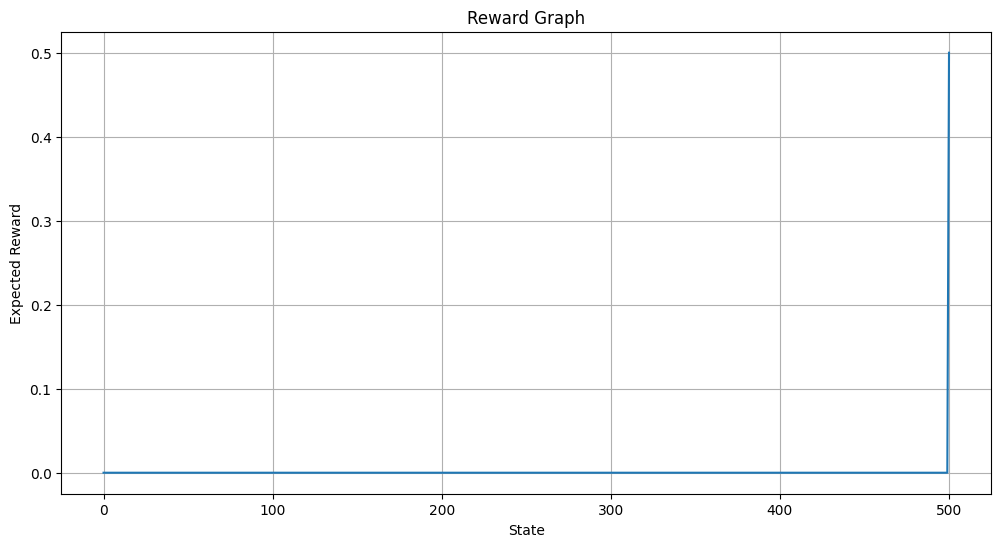

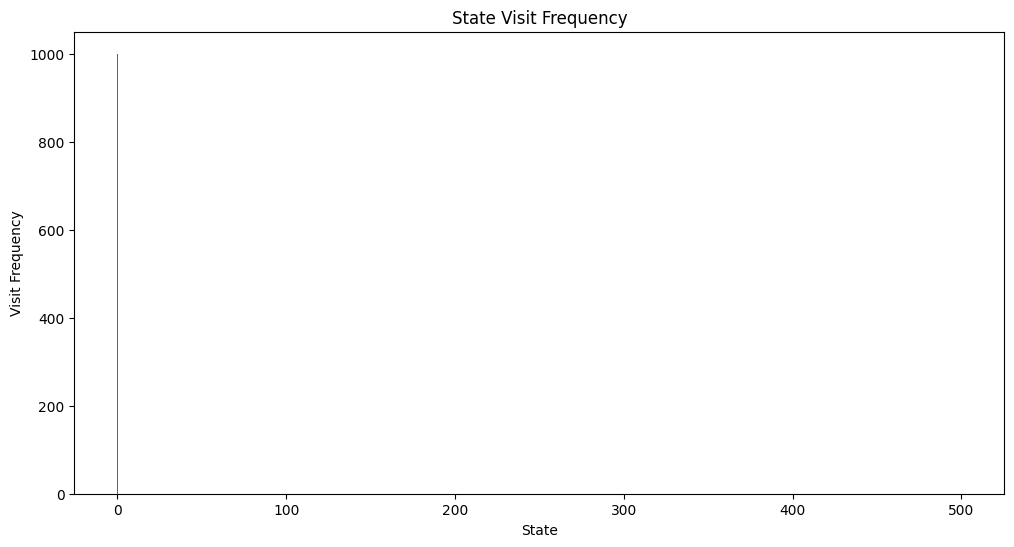

In [3]:
# Function to run policy iteration
def run_policy_iteration(env, gamma_values=[0.9, 0.95, 0.99, 1.0]):
    for gamma in gamma_values:
        planner = Planner(env.P)

        V, _, policy_dict = planner.policy_iteration(gamma=gamma)

        # Convert policy dict to a list if necessary
        pi = [policy_dict[state] for state in range(env.observation_space.n)]

        # Plotting the Value Function Graph
        plt.figure(figsize=(10, 6))
        plt.plot(V, label=f'Gamma = {gamma}')
        plt.xlabel('State')
        plt.ylabel('Value')
        plt.title('Value Function Graph')
        plt.legend()
        plt.show()

        # Plotting the Policy Graph
        plt.figure(figsize=(12, 6))
        plt.plot(pi, drawstyle='steps-post')
        plt.title('Policy Graph')
        plt.xlabel('Capital')
        plt.ylabel('Stake')
        plt.grid(True)
        plt.show()


        def plot_reward_graph(env, pi, title='Reward Graph'):
          rewards = []
          for state in range(env.observation_space.n):
            action = pi[state]
            # Given that the environment's model is accessible via `env.P`
            # and that it follows the structure: env.P[state][action] = [(prob, next_state, reward, done), ...]
            expected_reward = sum(prob * reward for prob, next_state, reward, done in env.P[state][action])
            rewards.append(expected_reward)

          plt.figure(figsize=(12, 6))
          plt.plot(rewards)
          plt.title(title)
          plt.xlabel('State')
          plt.ylabel('Expected Reward')
          plt.grid(True)
          plt.show()

        # Plot reward using `pi` and `env`
        plot_reward_graph(env, pi)

        def simulate_policy(env, pi, episodes=1000):
          state_visits = np.zeros(env.observation_space.n)

          for _ in range(episodes):
            state = env.reset()
            done = False
            while not done:
              action = pi[state]
              state_visits[state] += 1
              next_state, reward, done, _ = env.step(action)
              state = next_state

          return state_visits

        def plot_state_visit_frequency(state_visits, title='State Visit Frequency'):
          plt.figure(figsize=(12, 6))
          plt.bar(range(len(state_visits)), state_visits)
          plt.title(title)
          plt.xlabel('State')
          plt.ylabel('Visit Frequency')
          plt.show()


        state_visits = simulate_policy(env, pi)
        plot_state_visit_frequency(state_visits)


# Running the policy iteration
run_policy_iteration(env)


### Part 3: Running Value Iteration on the Gambler's Problem

runtime = 1.06 seconds


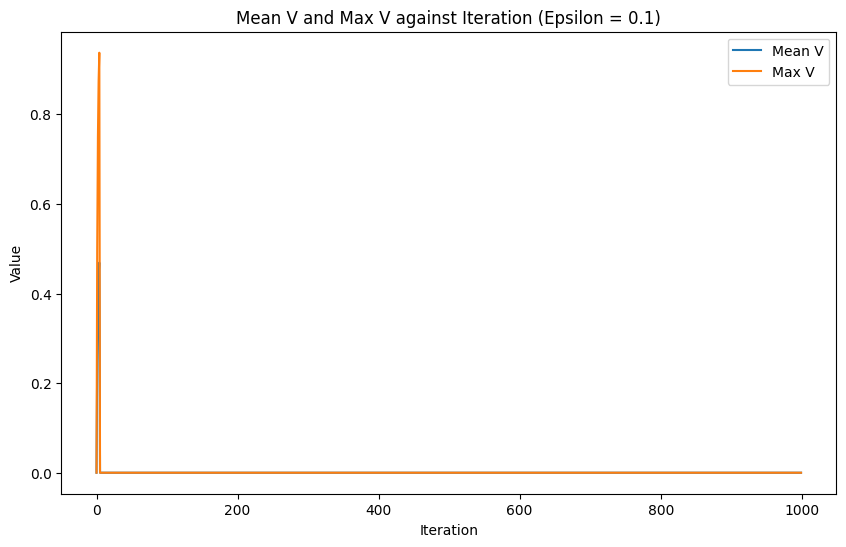

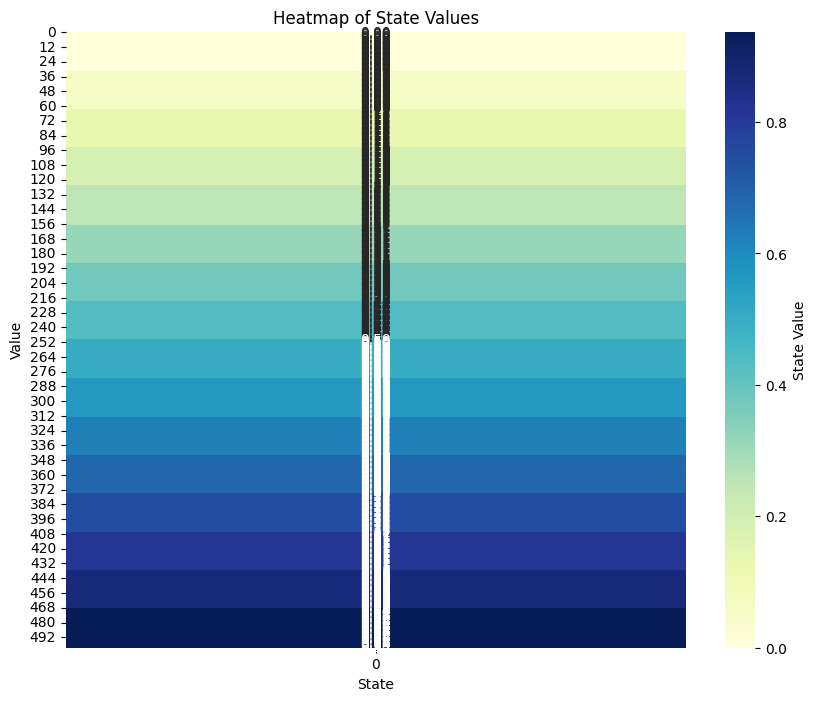

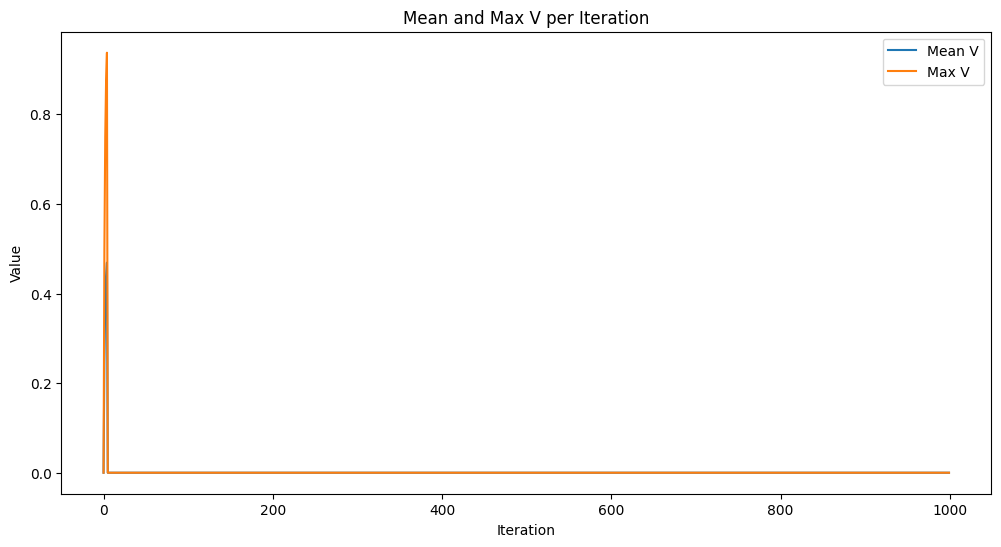

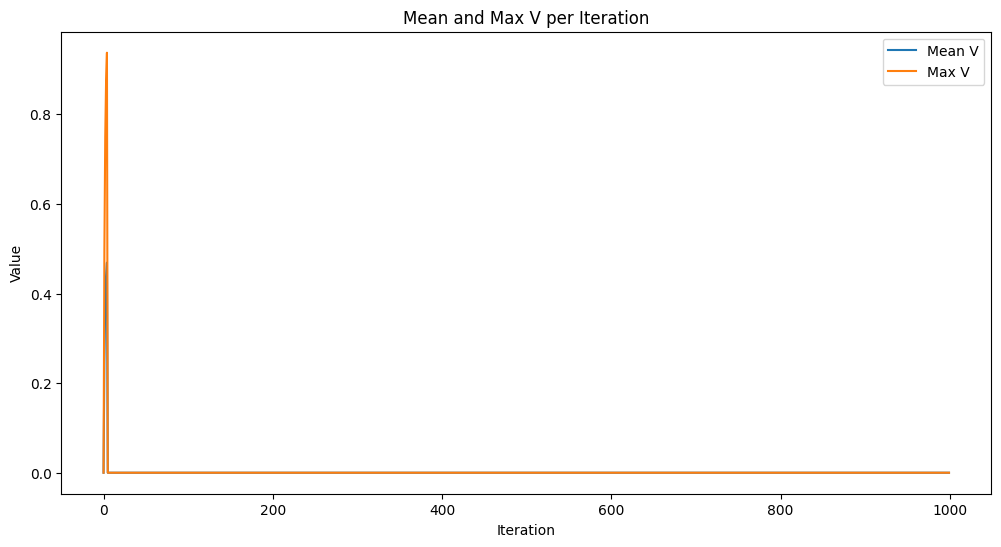

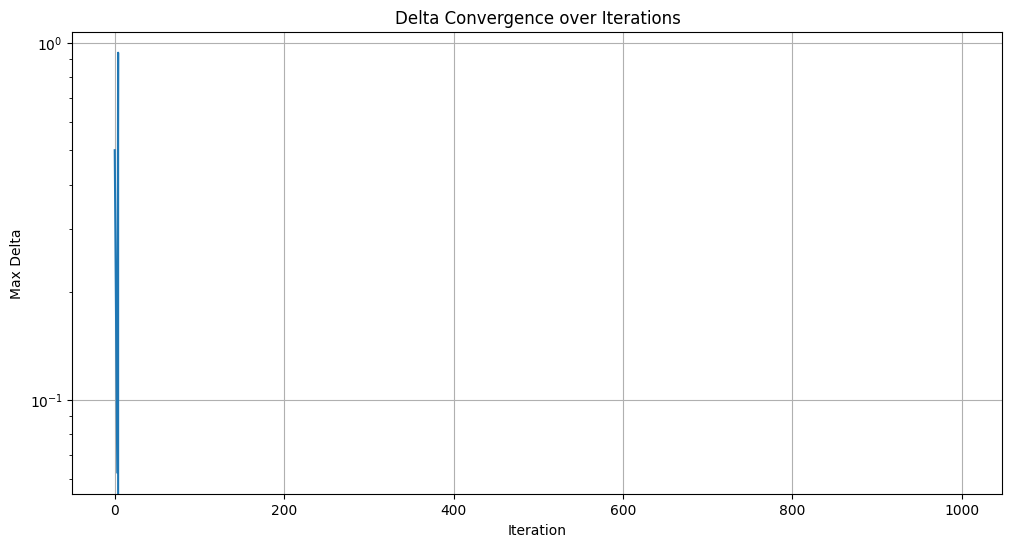

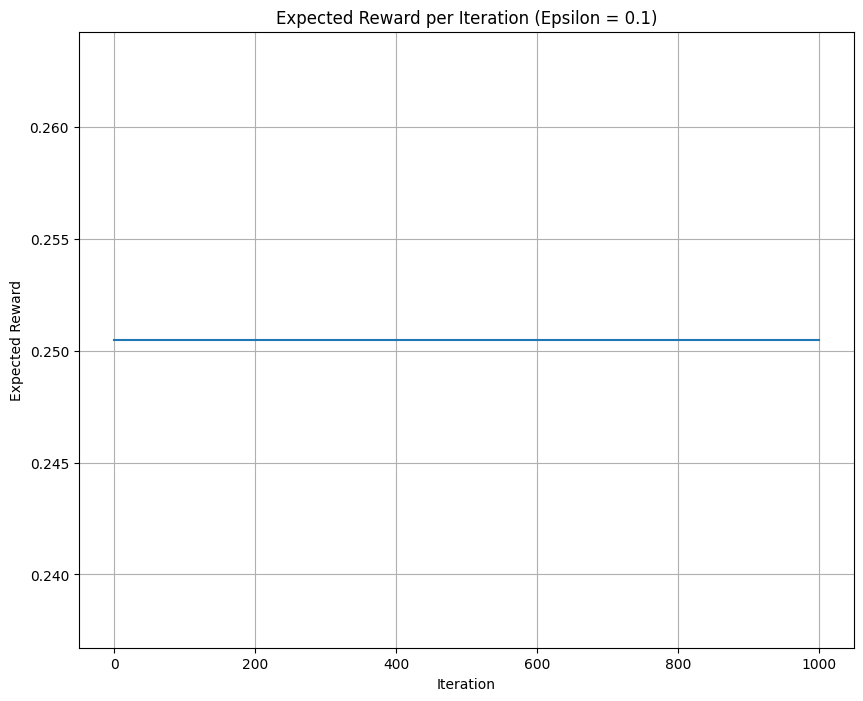

runtime = 1.84 seconds


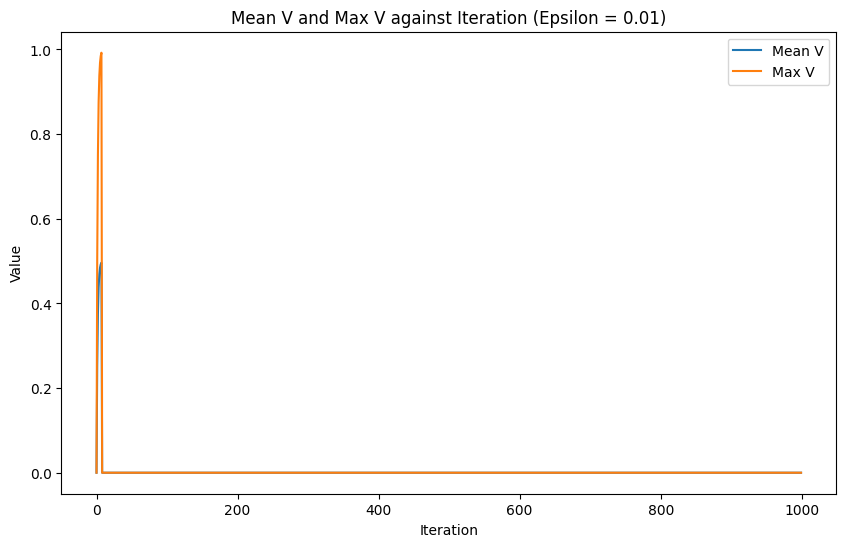

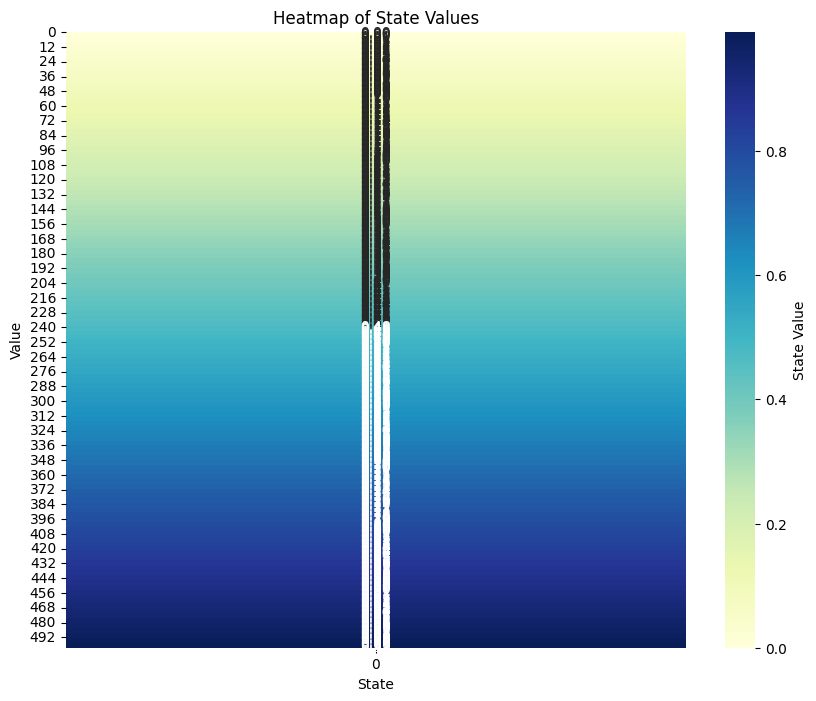

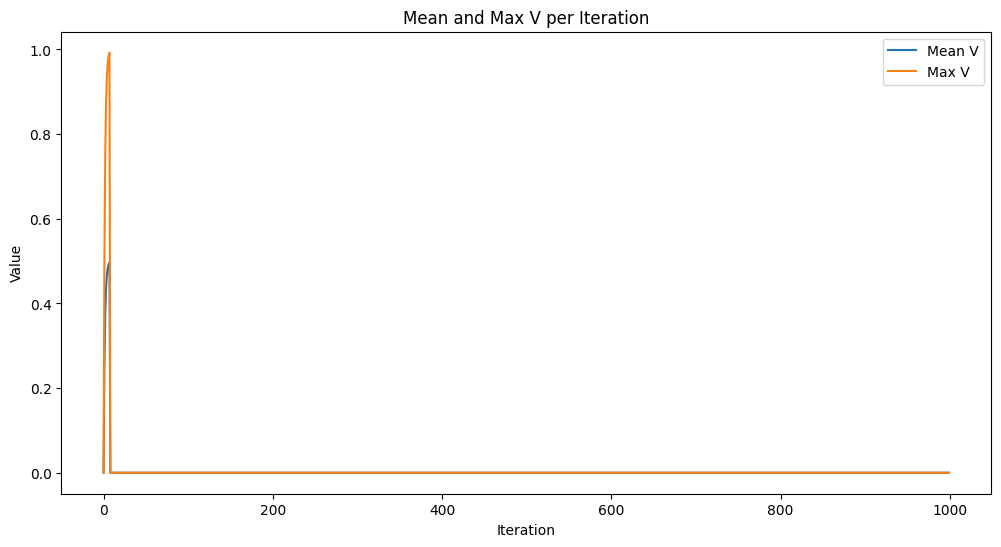

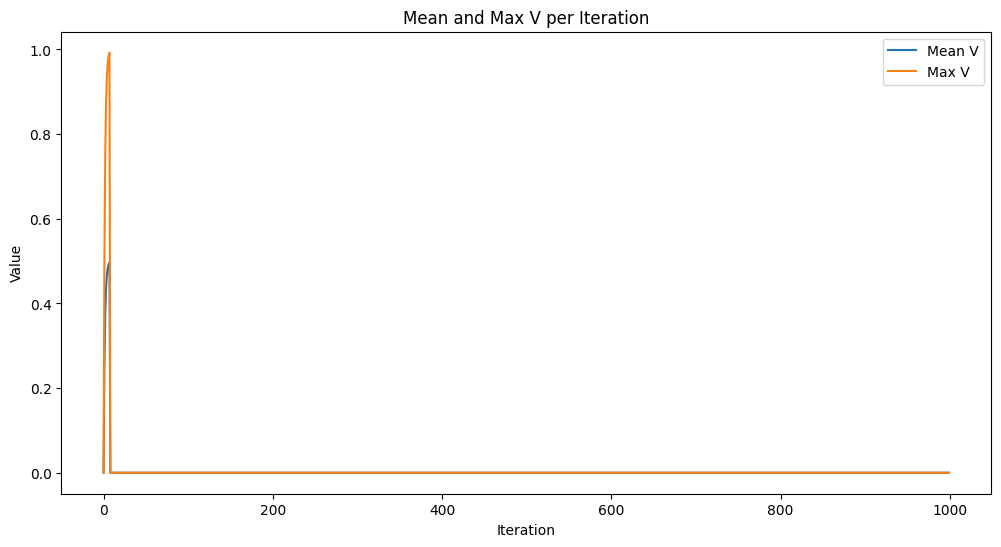

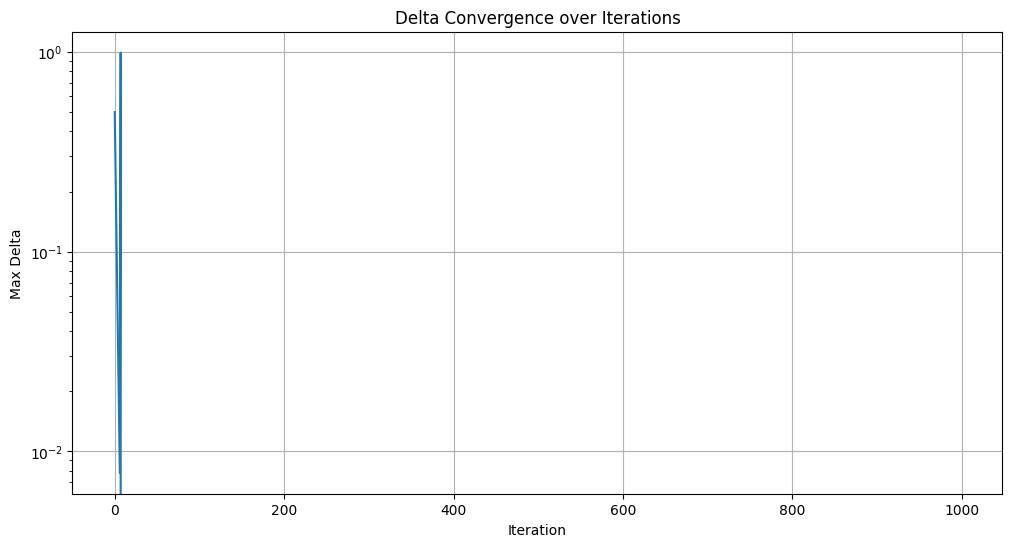

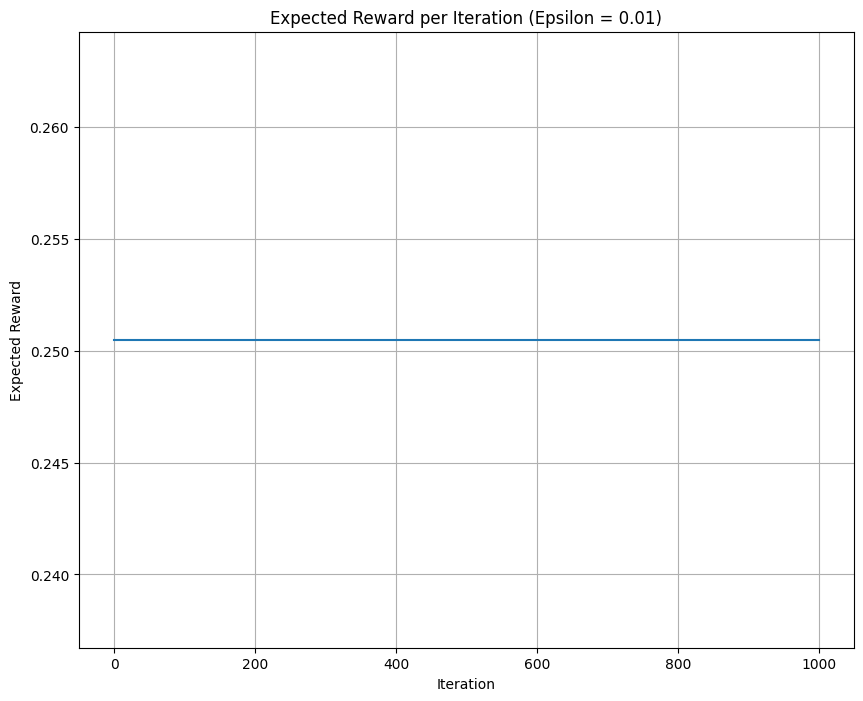

runtime = 2.66 seconds


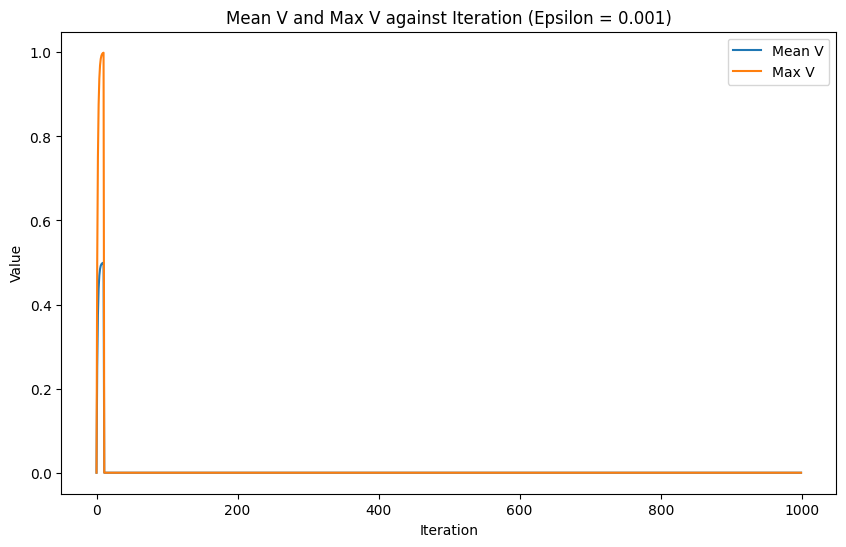

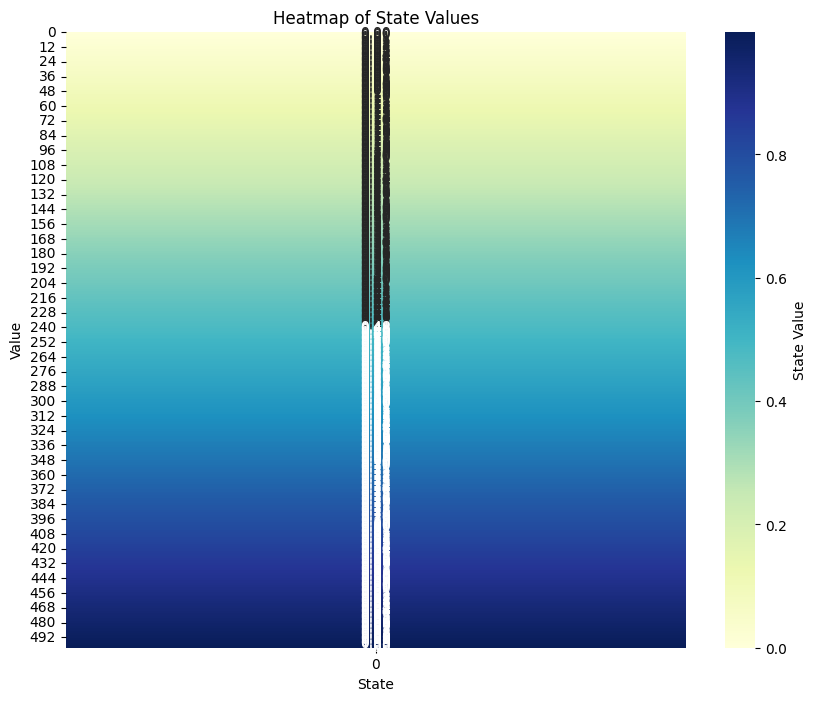

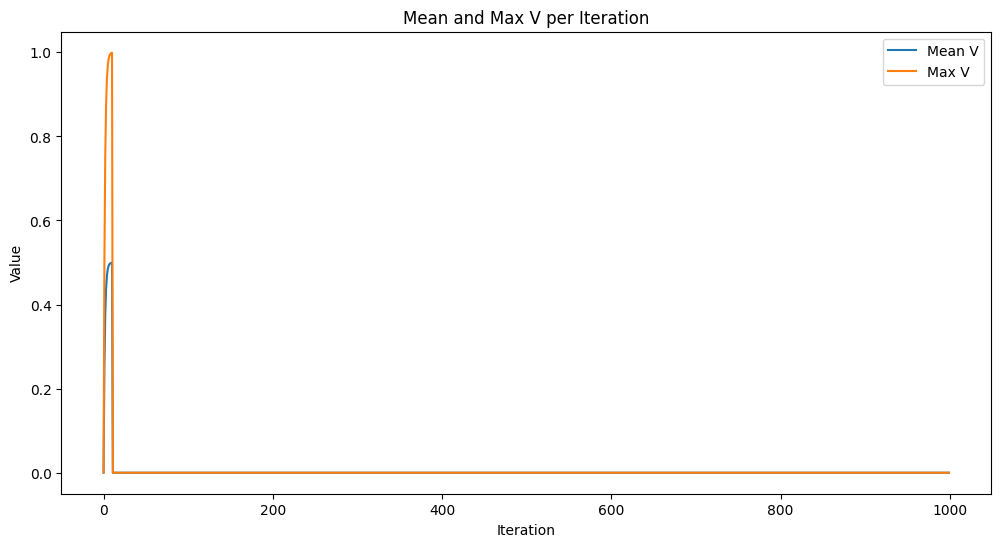

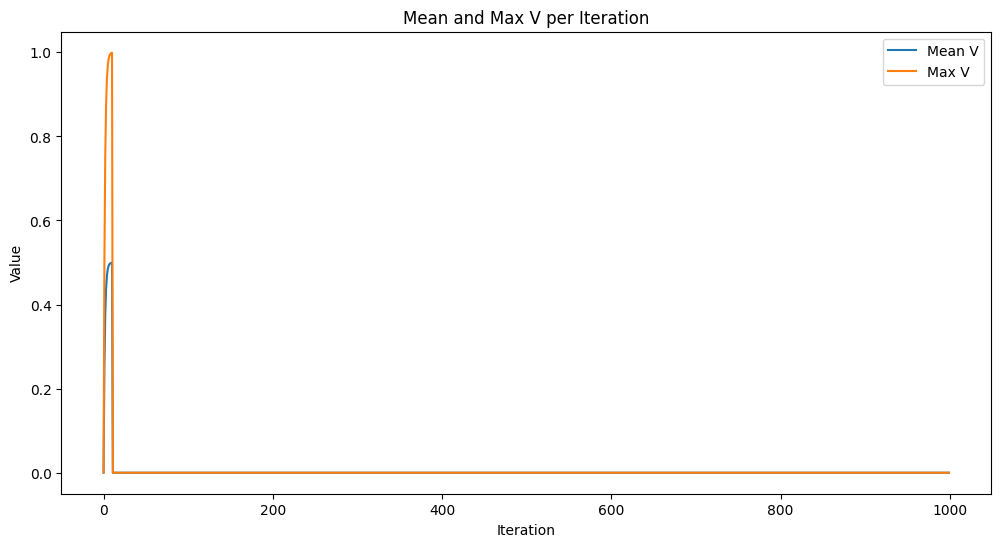

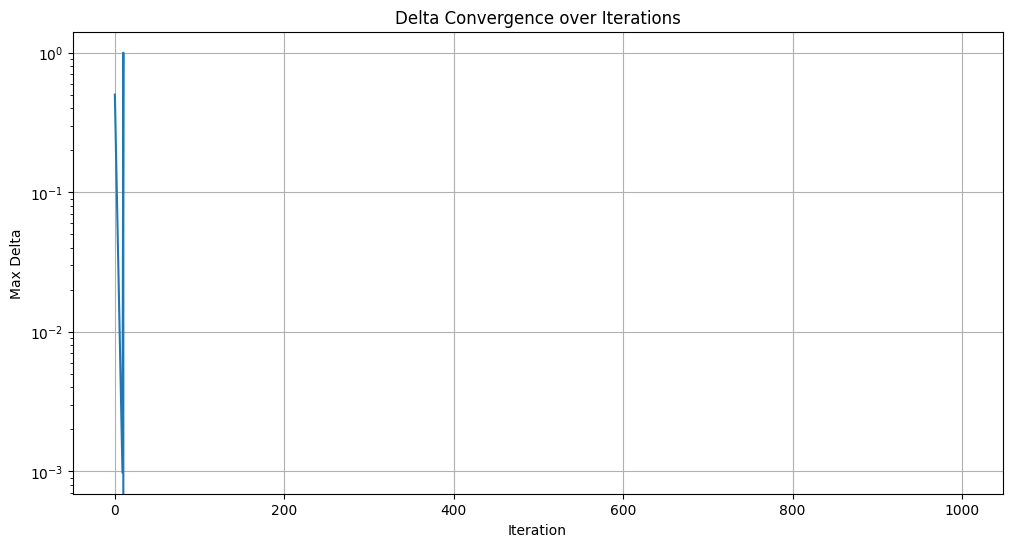

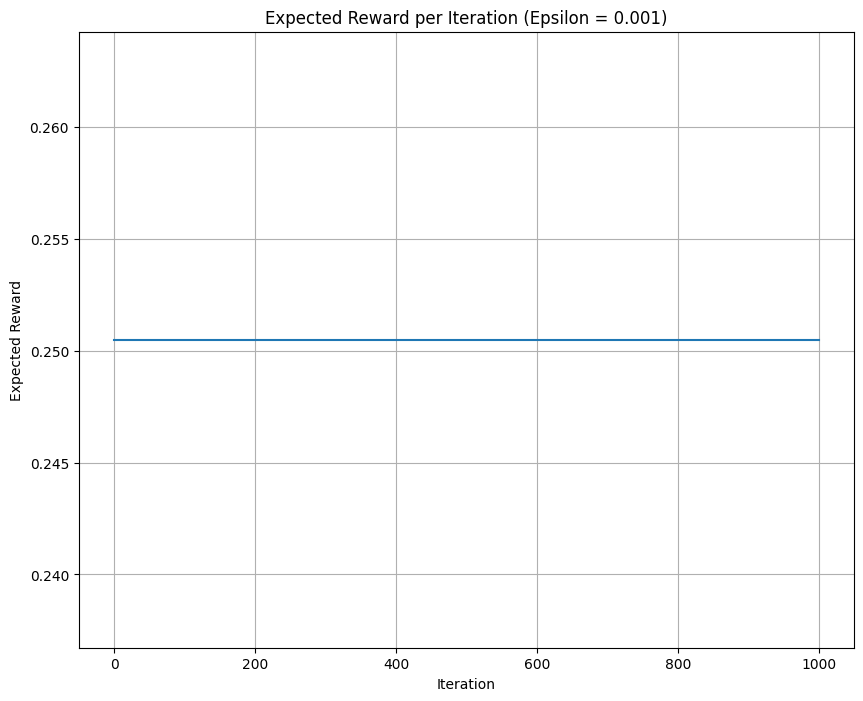

In [4]:
# Function to run value iteration
def run_value_iteration(env, epsilon_values=[0.1, 0.01, 0.001]):
    for epsilon in epsilon_values:
        planner = Planner(env.P)
        # V, V_track, pi = planner.value_iteration(theta=epsilon)
        V, V_track, _ = planner.value_iteration(theta=epsilon)

        # Plotting Mean V and Max V against Iteration
        mean_v = np.mean(V_track, axis=1)
        max_v = np.max(V_track, axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(mean_v, label='Mean V')
        plt.plot(max_v, label='Max V')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title(f'Mean V and Max V against Iteration (Epsilon = {epsilon})')
        plt.legend()
        plt.show()


        import seaborn as sns

        def plot_state_value_heatmap(V, title='Heatmap of State Values'):

          state_values_matrix = V.reshape(-1, 1)

          plt.figure(figsize=(10, 8))
          sns.heatmap(state_values_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'State Value'})
          plt.title(title)
          plt.xlabel('State')
          plt.ylabel('Value')
          plt.show()


        plot_state_value_heatmap(V)

        def plot_mean_max_v_iteration(V_track, title='Mean and Max V per Iteration'):
          mean_v = np.mean(V_track, axis=1)  # Average value per iteration across all states
          max_v = np.max(V_track, axis=1)  # Max value per iteration across all states

          plt.figure(figsize=(12, 6))
          plt.plot(mean_v, label='Mean V')
          plt.plot(max_v, label='Max V')
          plt.title(title)
          plt.xlabel('Iteration')
          plt.ylabel('Value')
          plt.legend()
          plt.show()


        plot_mean_max_v_iteration(V_track)

        def plot_mean_max_v_iteration(V_track, title='Mean and Max V per Iteration'):
          mean_v = np.mean(V_track, axis=1)  # Average value per iteration across all states
          max_v = np.max(V_track, axis=1)  # Max value per iteration across all states

          plt.figure(figsize=(12, 6))
          plt.plot(mean_v, label='Mean V')
          plt.plot(max_v, label='Max V')
          plt.title(title)
          plt.xlabel('Iteration')
          plt.ylabel('Value')
          plt.legend()
          plt.show()


        plot_mean_max_v_iteration(V_track)

        def plot_delta_convergence(V_track, title='Delta Convergence over Iterations'):
          deltas = np.max(np.abs(np.diff(V_track, axis=0)), axis=1)

          plt.figure(figsize=(12, 6))
          plt.plot(deltas)
          plt.title(title)
          plt.xlabel('Iteration')
          plt.ylabel('Max Delta')
          plt.yscale('log')
          plt.grid(True)
          plt.show()


        plot_delta_convergence(V_track)

        reward_track = []
        for V_i in V_track:

            action_values = np.array([[sum(prob * (reward + V_i[next_state]) for prob, next_state, reward, done in env.P[s][a]) for a in env.P[s]] for s in range(env.observation_space.n)])
            pi_i = np.argmax(action_values, axis=1)
            expected_rewards = [sum(env.P[s][pi_i[s]][i][0] * env.P[s][pi_i[s]][i][2] for i in range(len(env.P[s][pi_i[s]]))) for s in range(env.observation_space.n)]
            reward_track.append(np.mean(expected_rewards))

        plt.figure(figsize=(10, 8))
        plt.plot(reward_track)
        plt.title(f'Expected Reward per Iteration (Epsilon = {epsilon})')
        plt.xlabel('Iteration')
        plt.ylabel('Expected Reward')
        plt.grid(True)
        plt.show()


# Running the value iteration
run_value_iteration(env)


### Part 4: Implementing Q-Learning on the Gambler's Problem

In [5]:
class EnvWrapper:
    def __init__(self, env):
        self.env = env

    def reset(self):
        state = self.env.reset()
        return state, {}  # Return a tuple as expected by the Q-learning method

    def step(self, action):
        # return self.env.step(action)
        next_state, reward, done, info = self.env.step(action)
        return next_state, reward, done, False, info  # Adapt step to return a 5-tuple

    # Delegate attribute access to the underlying environment
    def __getattr__(self, name):
        return getattr(self.env, name)


In [6]:

class RL:
    def __init__(self, env):
        self.env = env
        self.nS = env.observation_space.n
        self.nA = env.action_space.n
        self.Q = np.zeros((self.nS, self.nA))

    def q_learning(self, n_episodes, alpha, gamma, epsilon):
        rewards = []
        Q_track = []

        for episode in range(n_episodes):
            total_reward = 0
            state = self.env.reset()
            done = False

            while not done:
                if np.random.rand() < epsilon:
                    action = self.env.action_space.sample()  # Explore
                else:
                    action = np.argmax(self.Q[state])  # Exploit

                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                # Update Q-value using the Q-learning formula
                self.Q[state, action] = self.Q[state, action] + alpha * (
                    reward + gamma * np.max(self.Q[next_state]) - self.Q[state, action])

                state = next_state

            rewards.append(total_reward)
            Q_track.append(np.copy(self.Q))

        return self.Q, rewards, np.array(Q_track)


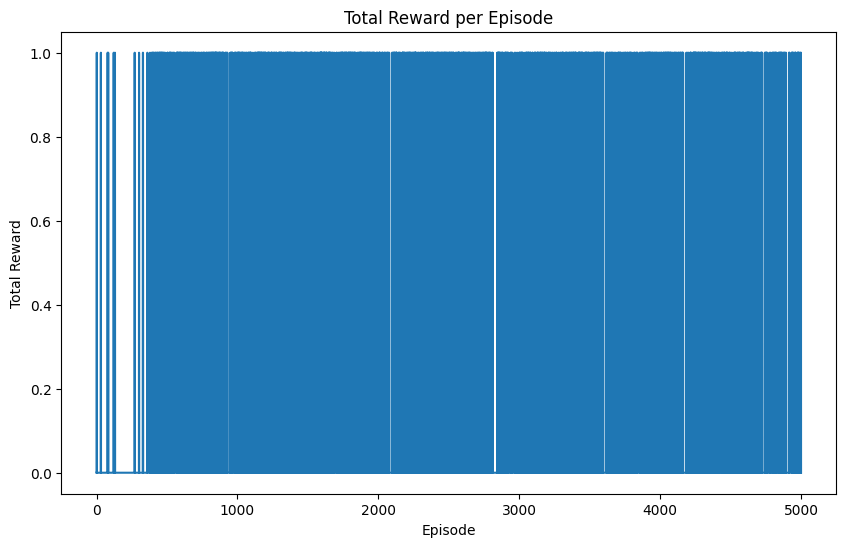

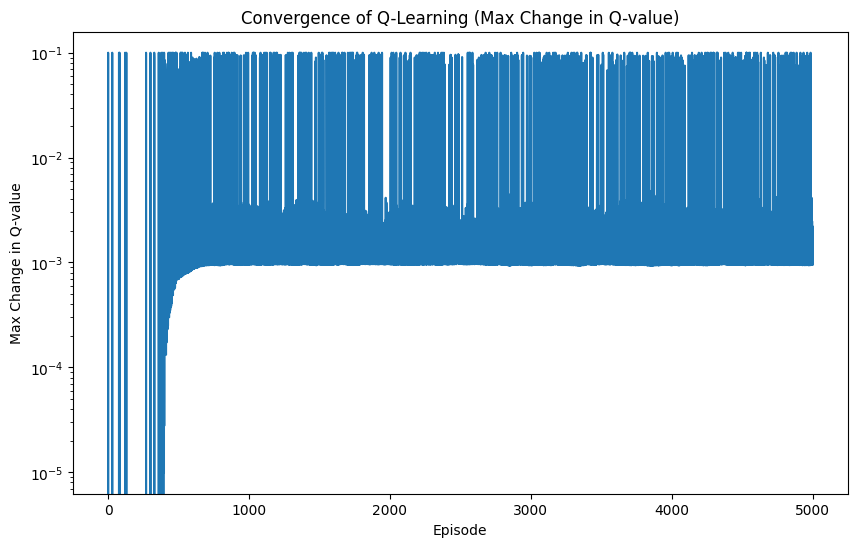

In [7]:

def run_q_learning(env, episodes=5000, alpha=0.1, gamma=0.99, epsilon=0.1):
    agent = RL(env)

    Q, rewards, Q_track = agent.q_learning(
        n_episodes=episodes,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon
    )

    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    deltas = np.max(np.abs(np.diff(Q_track, axis=0)), axis=(1, 2))
    plt.figure(figsize=(10, 6))
    plt.plot(deltas)
    plt.title("Convergence of Q-Learning (Max Change in Q-value)")
    plt.xlabel("Episode")
    plt.ylabel("Max Change in Q-value")
    plt.yscale("log")
    plt.show()

env = GamblersProblemEnv()
run_q_learning(env)

### Part 5: Measuring Execution Times

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


runtime = 5.15 seconds


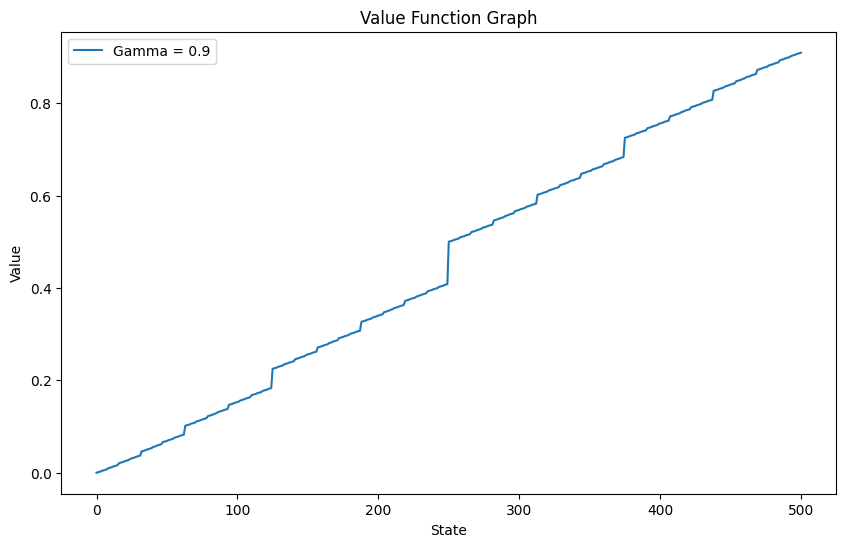

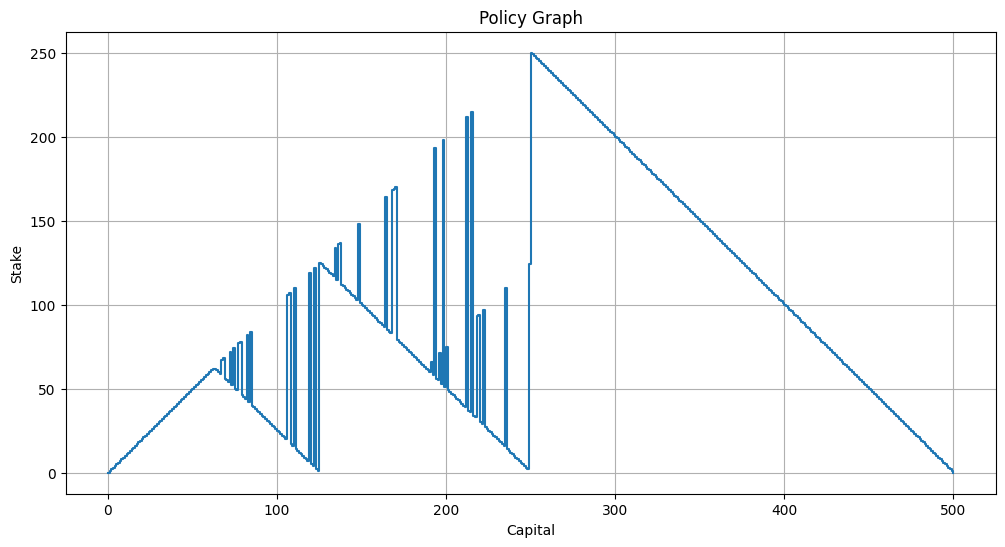

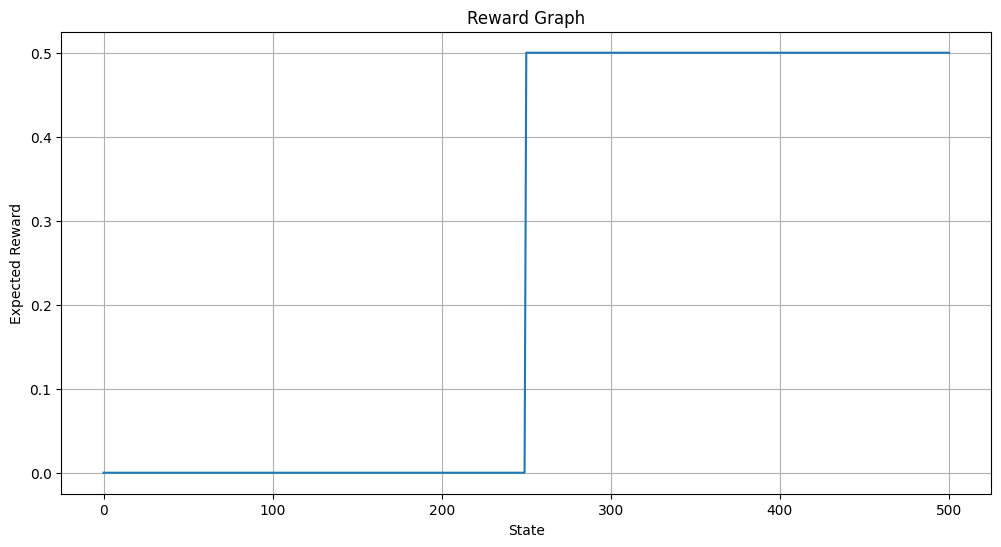

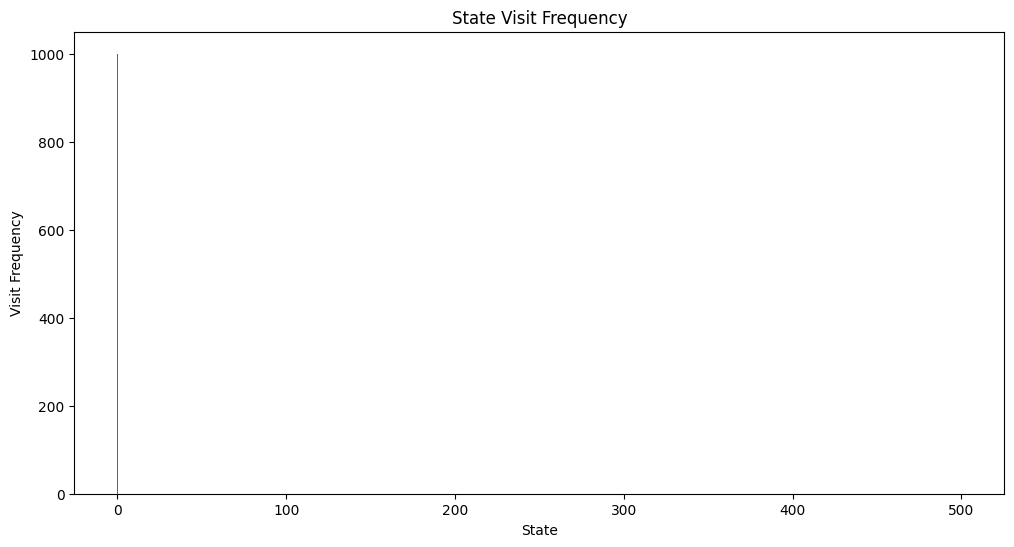

runtime = 4.38 seconds


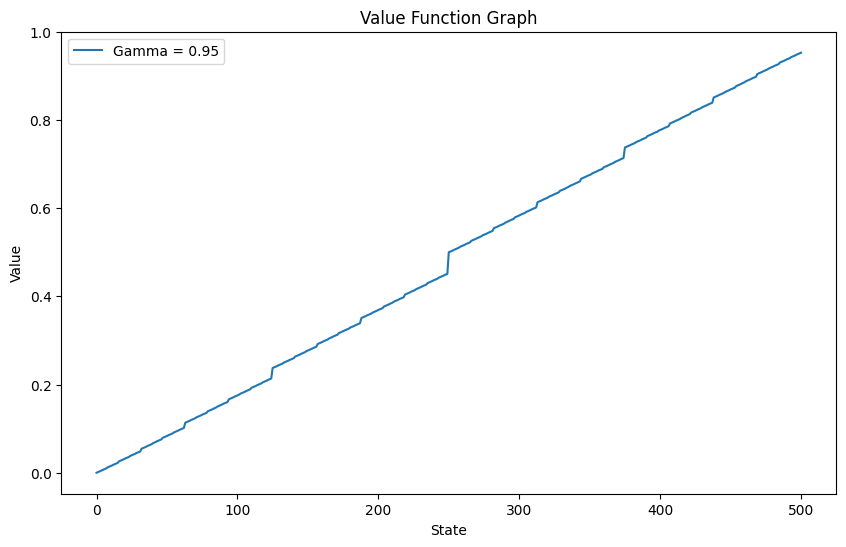

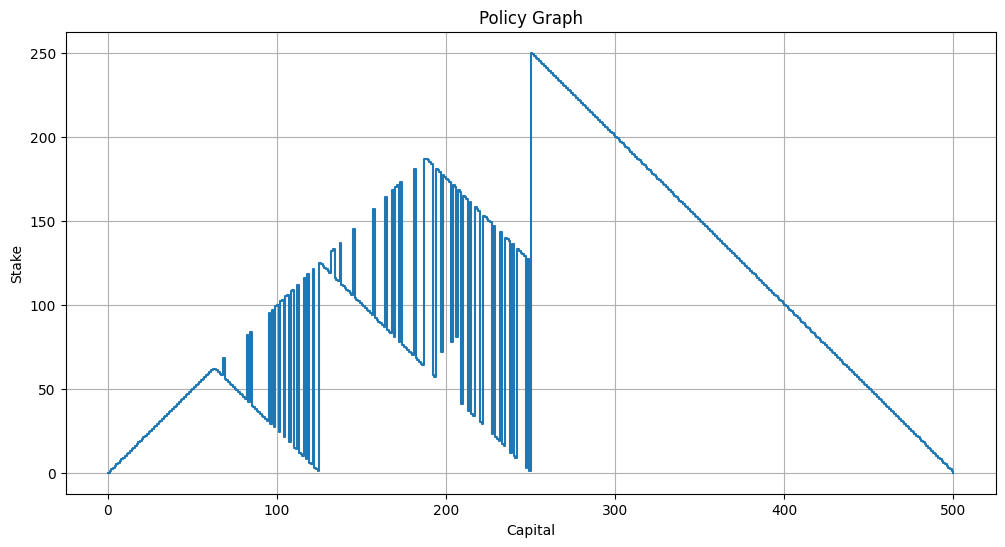

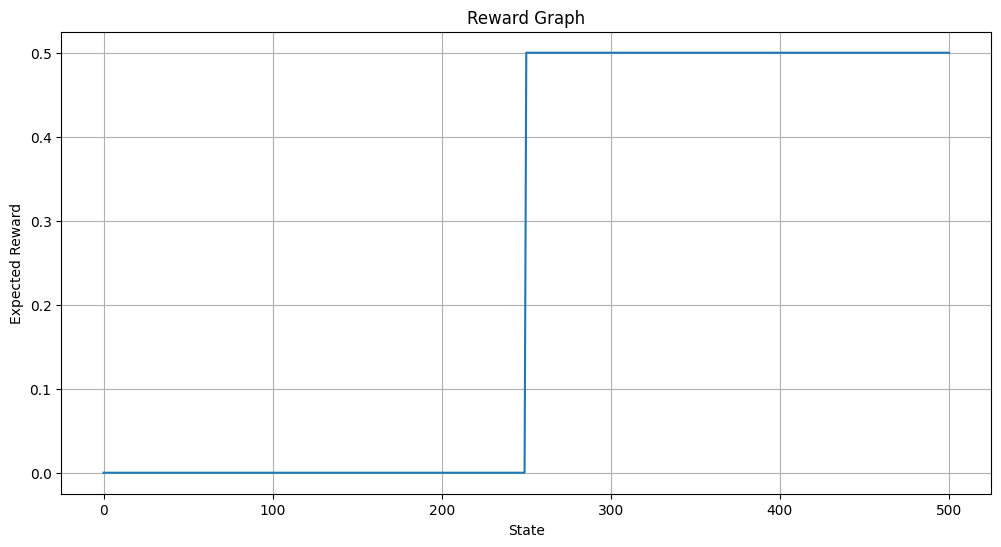

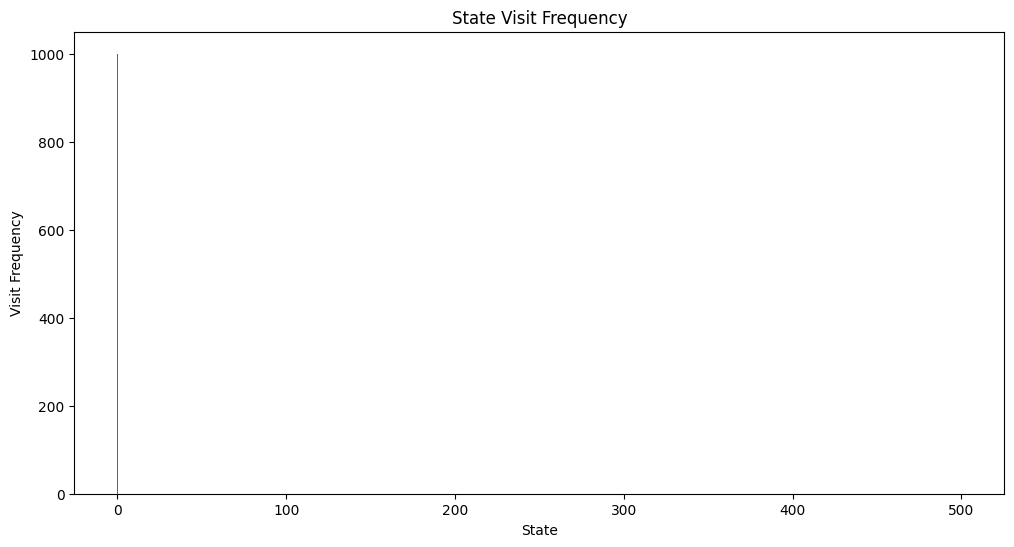

runtime = 7.82 seconds


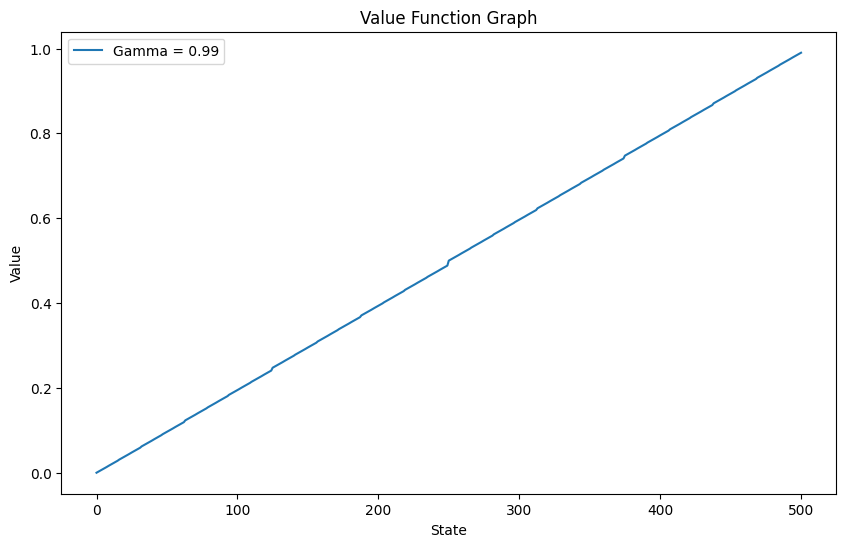

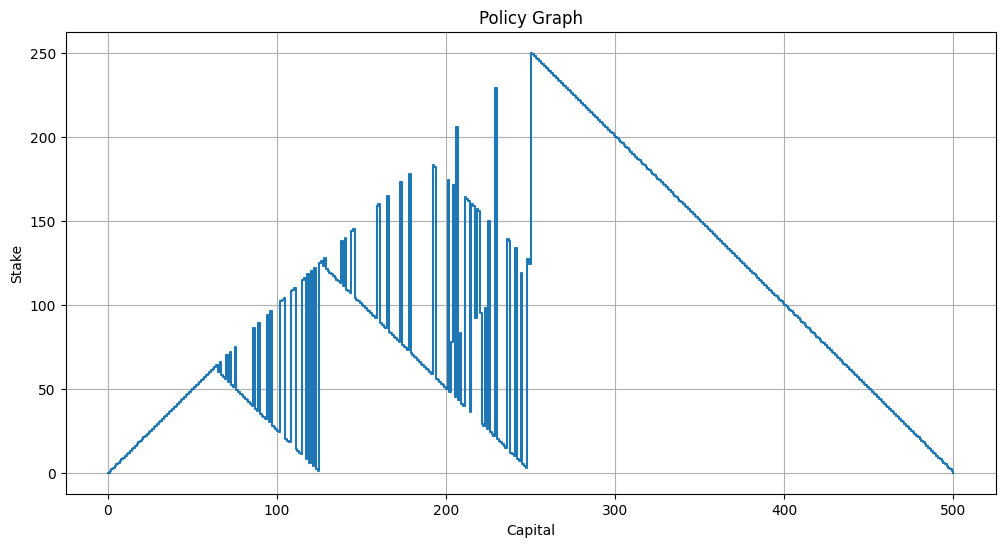

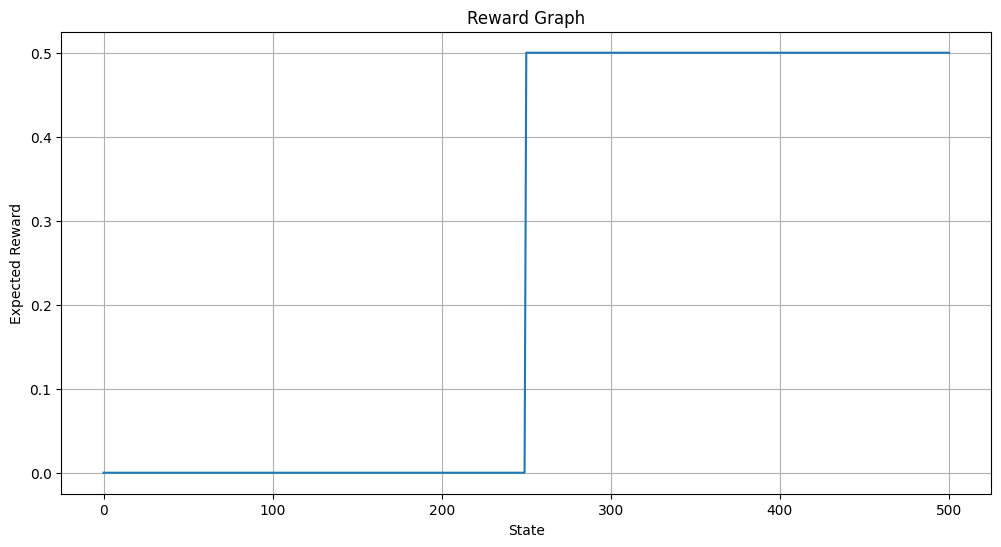

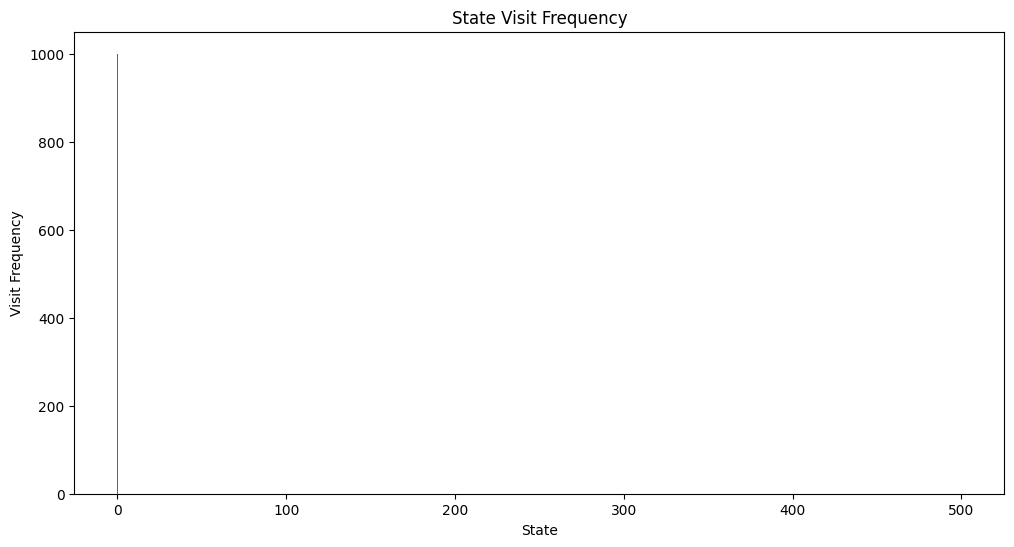

runtime = 13.08 seconds


/usr/local/lib/python3.10/dist-packages/bettermdptools/algorithms/planner.py:126: UserWarning: Max iterations reached before convergence.  Check n_iters.
  warnings.warn("Max iterations reached before convergence.  Check n_iters.")


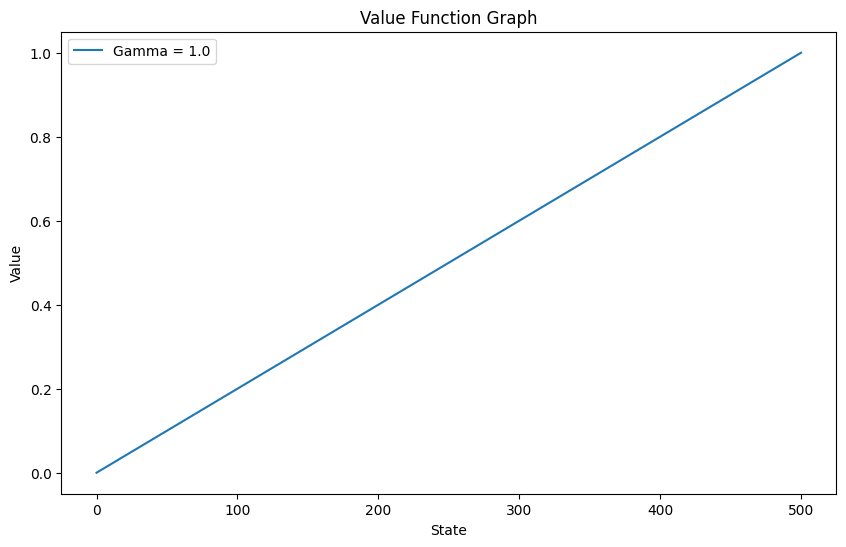

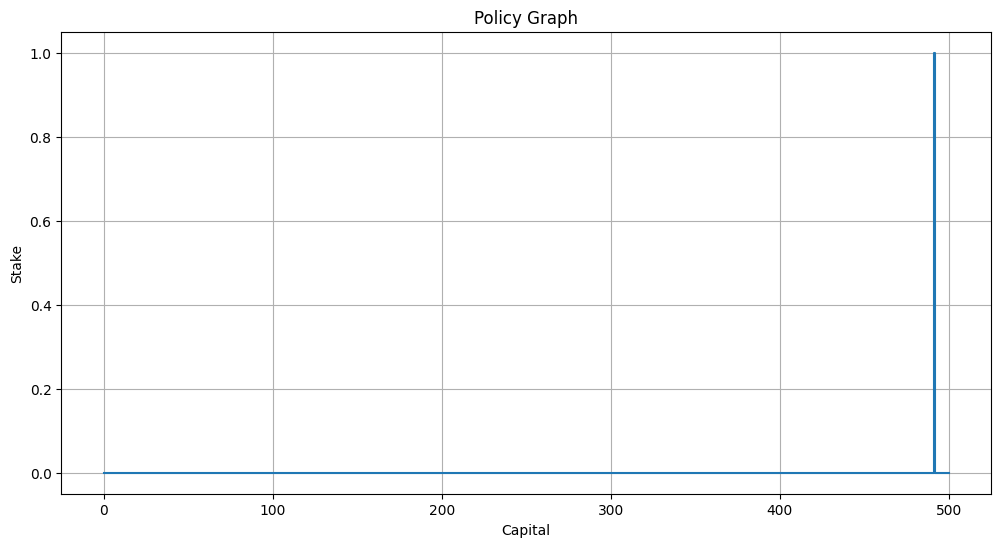

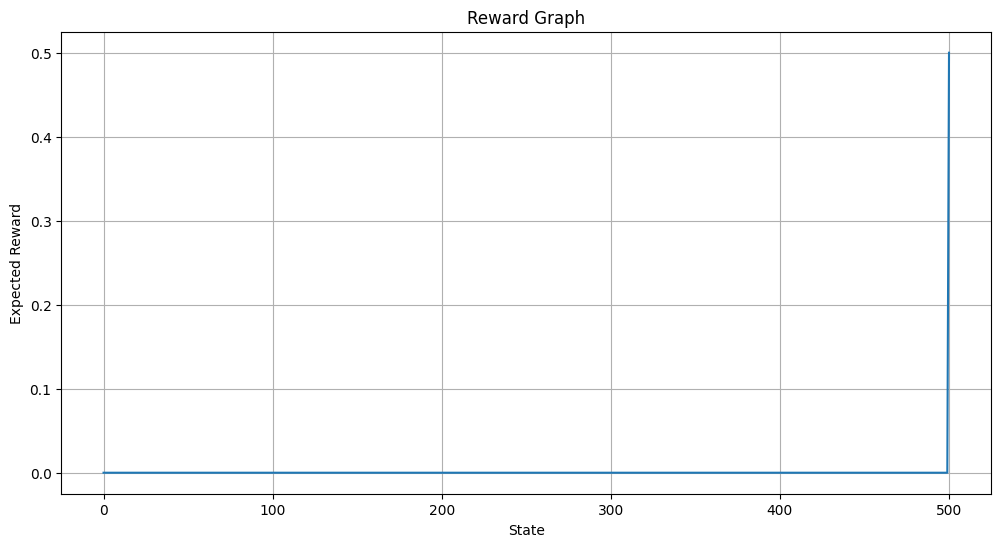

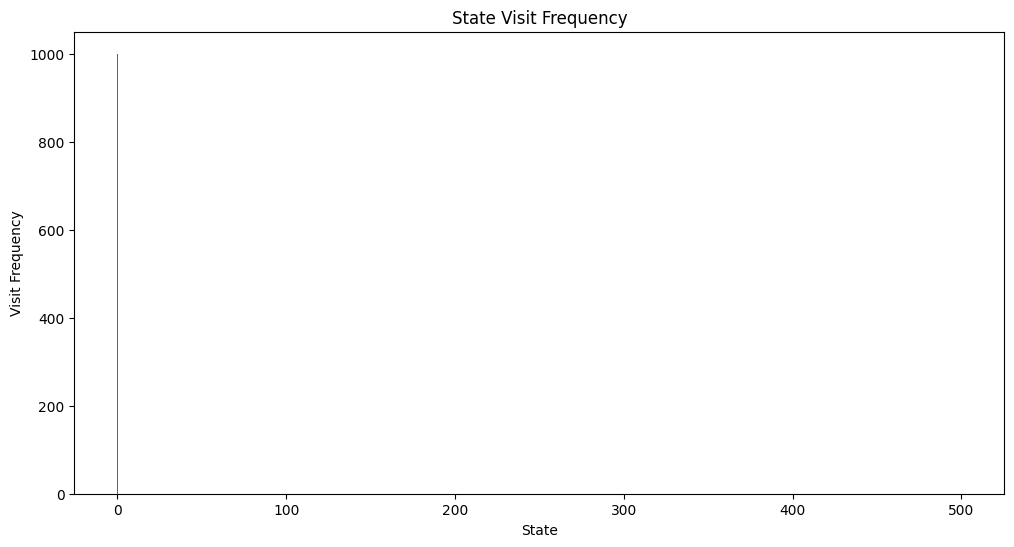

run_policy_iteration took 34.9420 seconds to complete.
runtime = 1.07 seconds


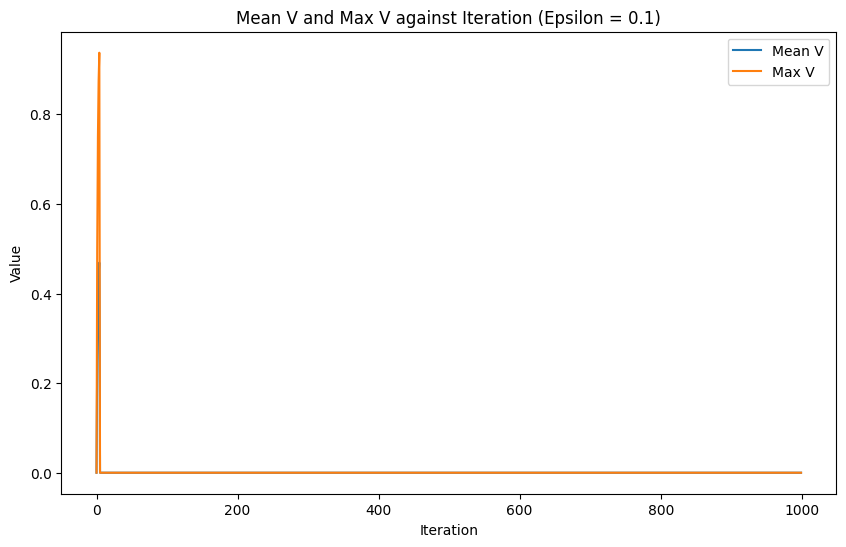

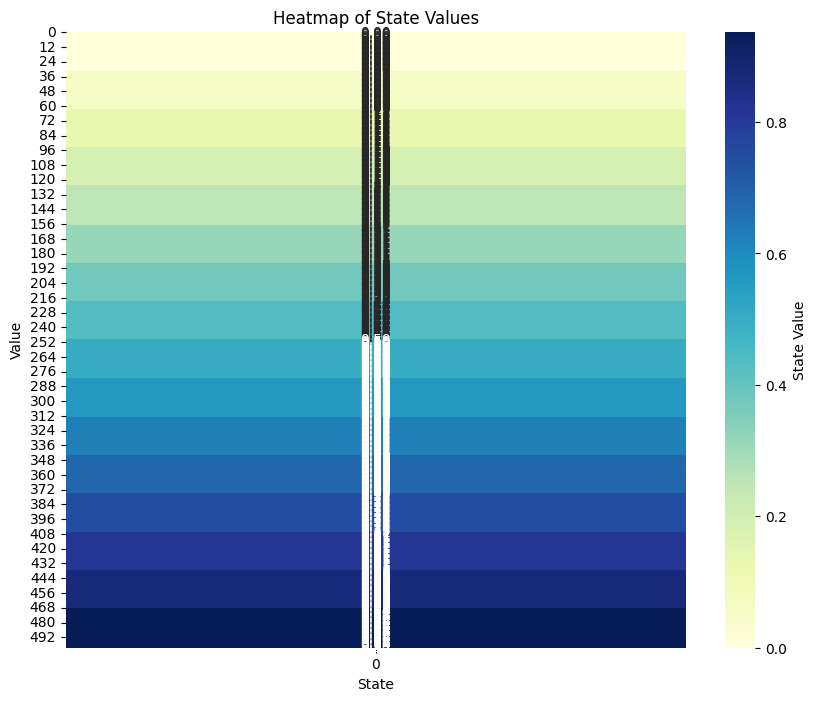

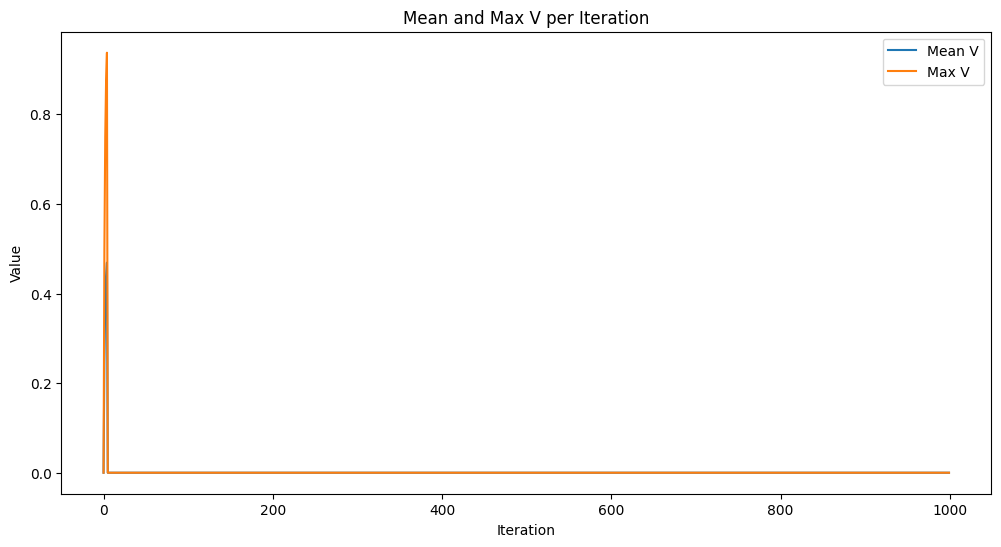

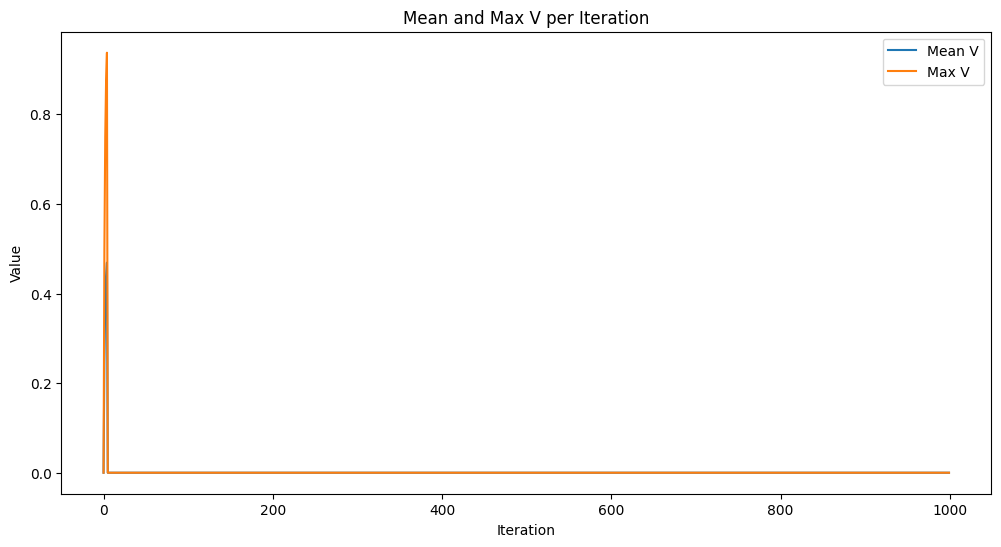

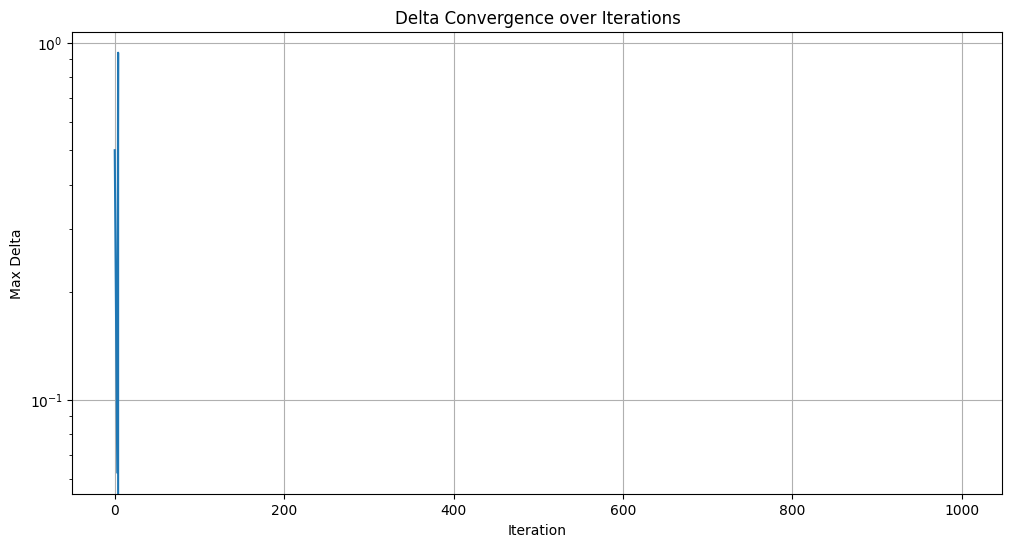

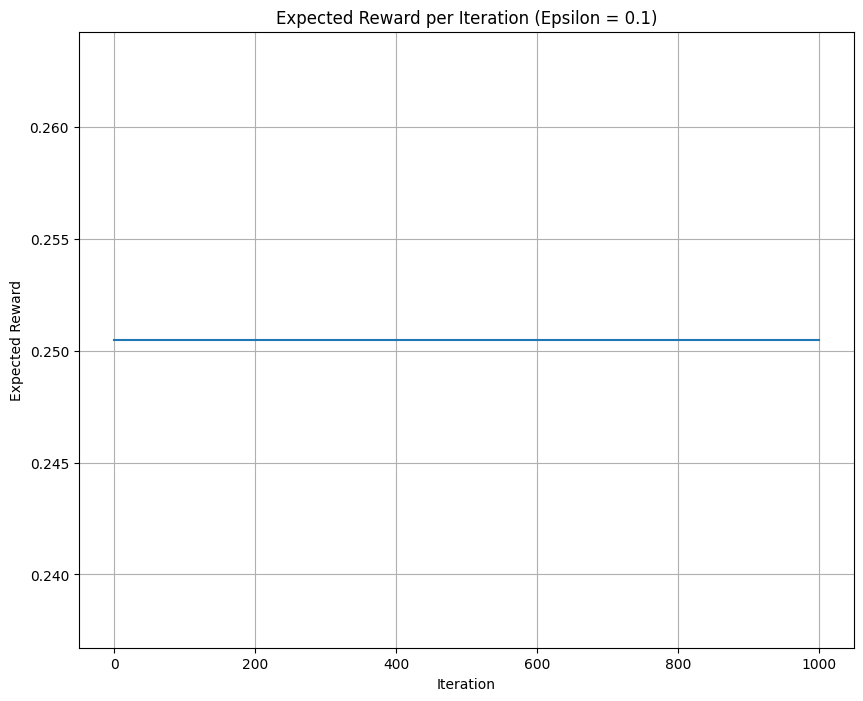

runtime = 1.84 seconds


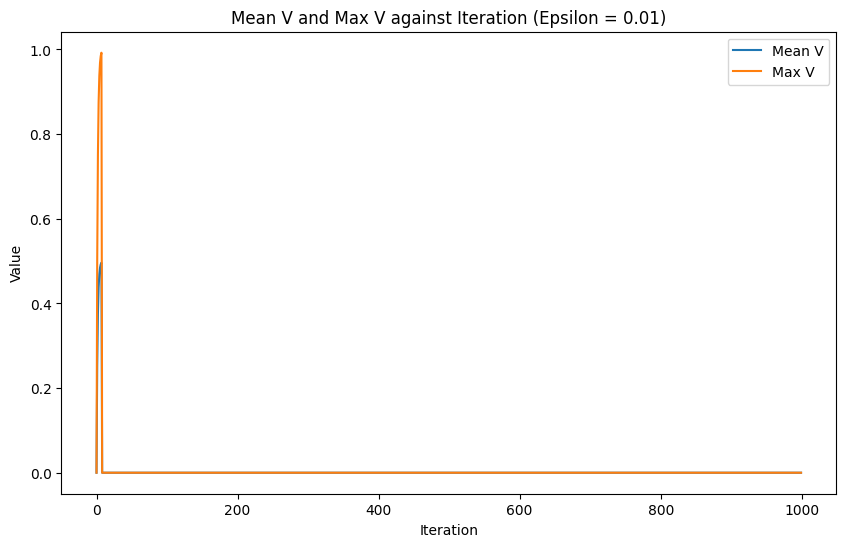

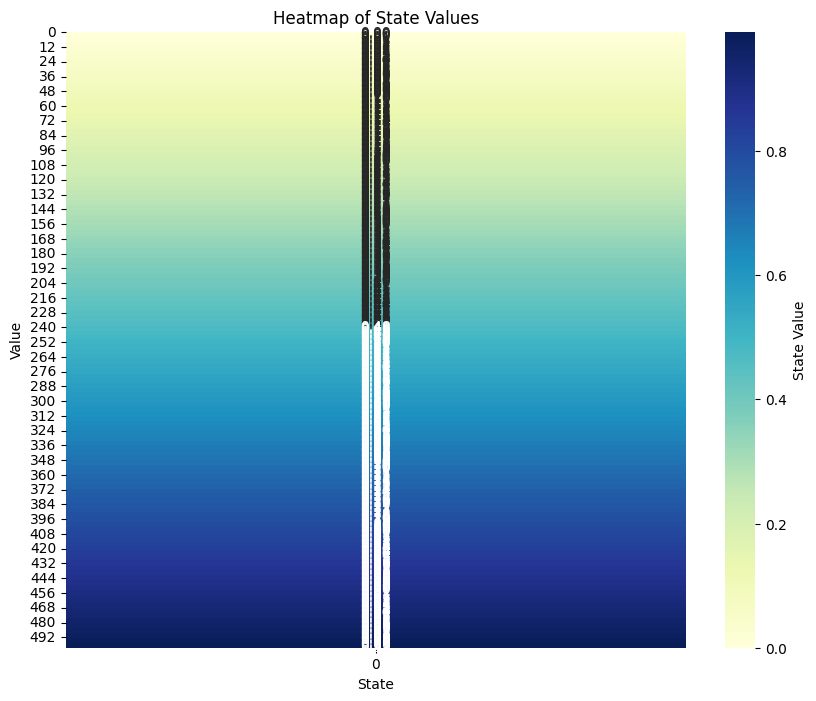

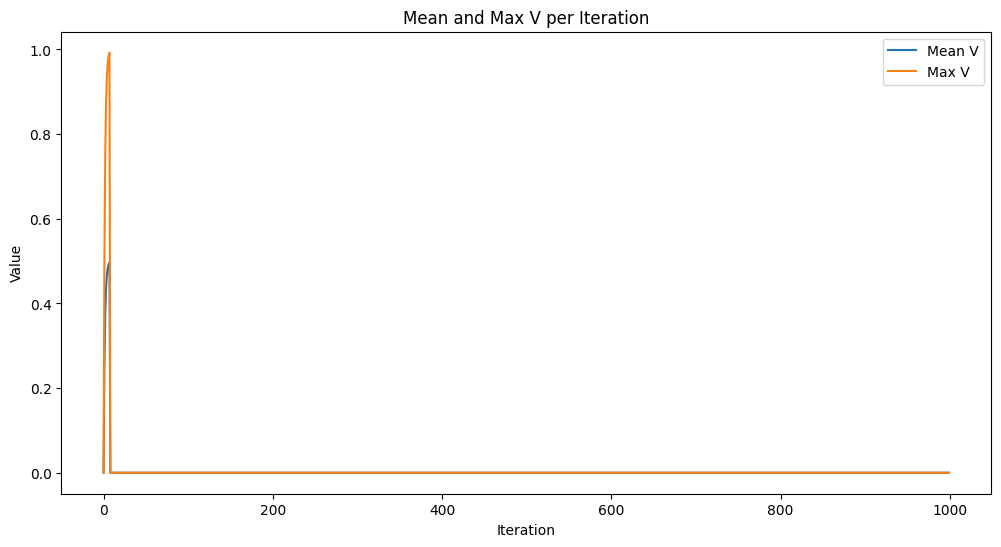

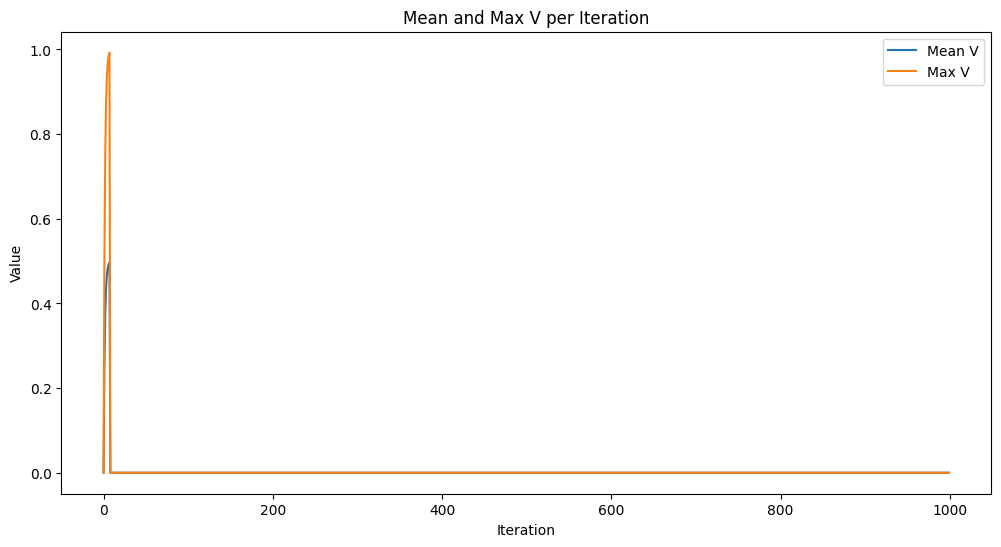

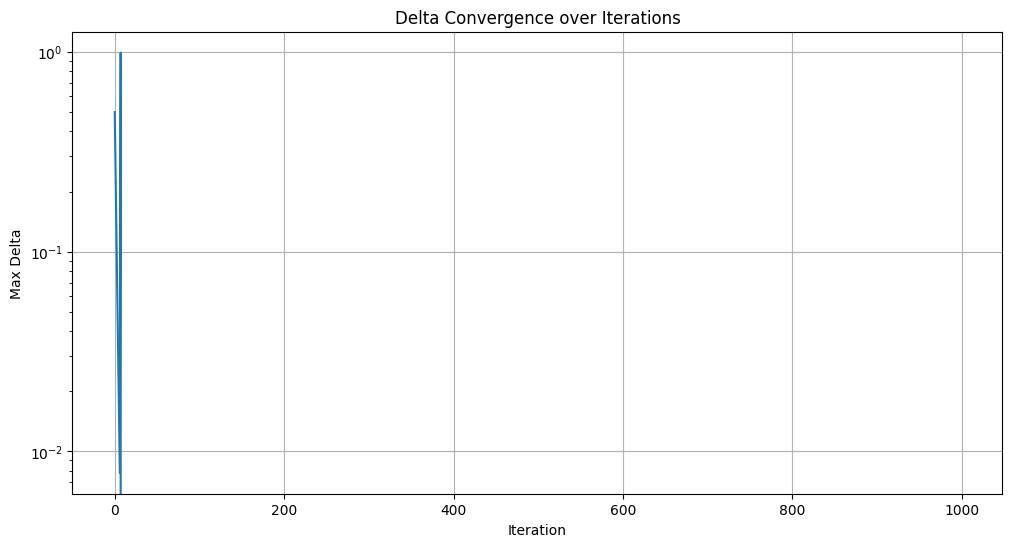

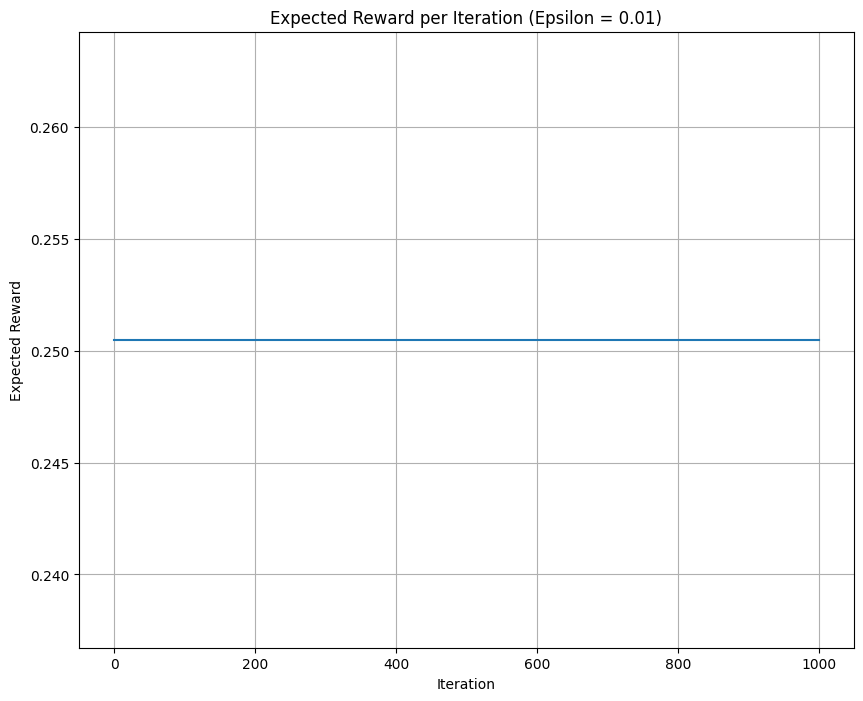

runtime = 2.62 seconds


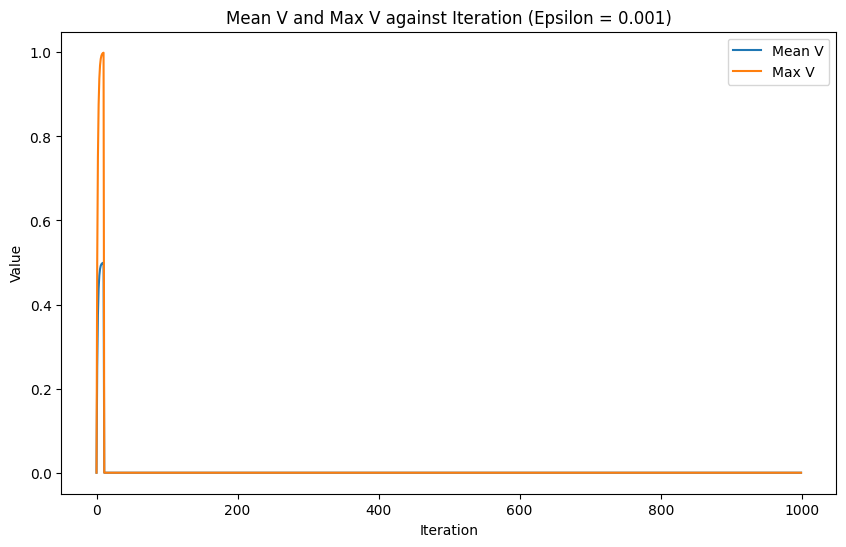

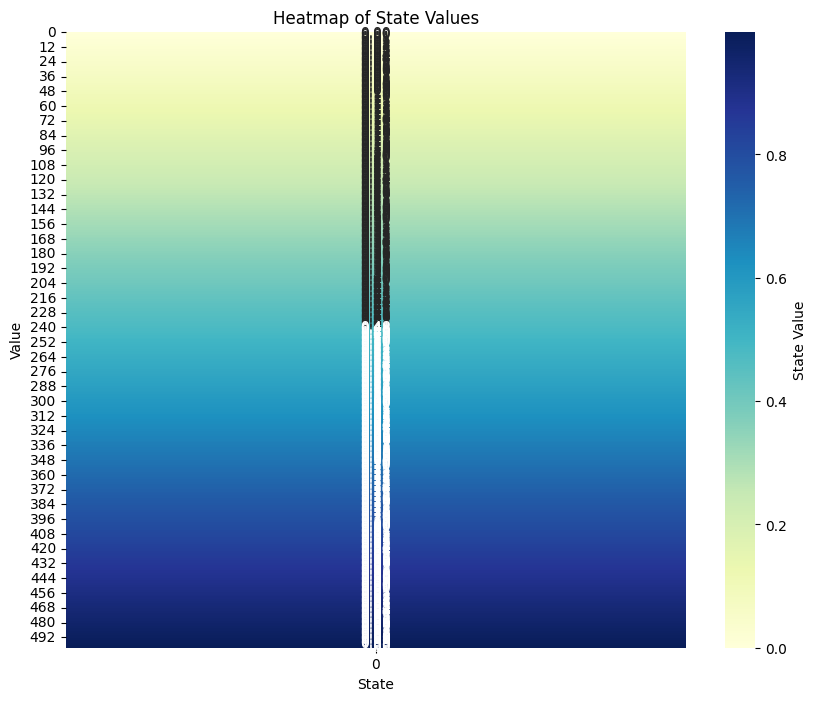

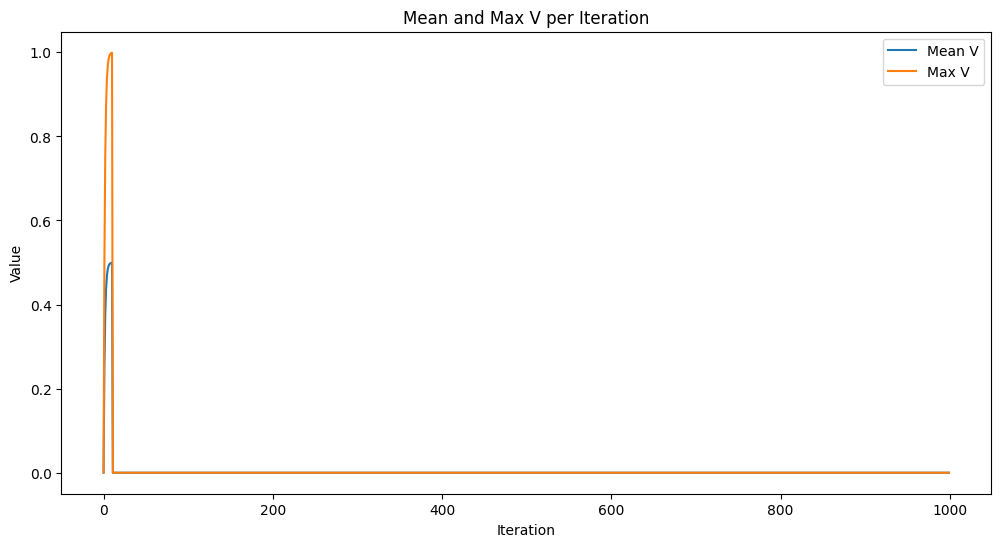

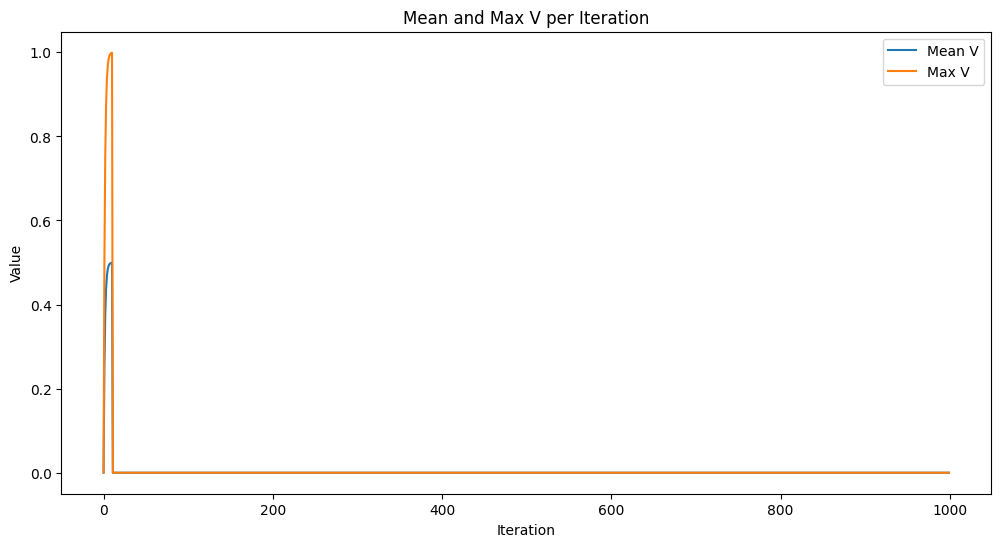

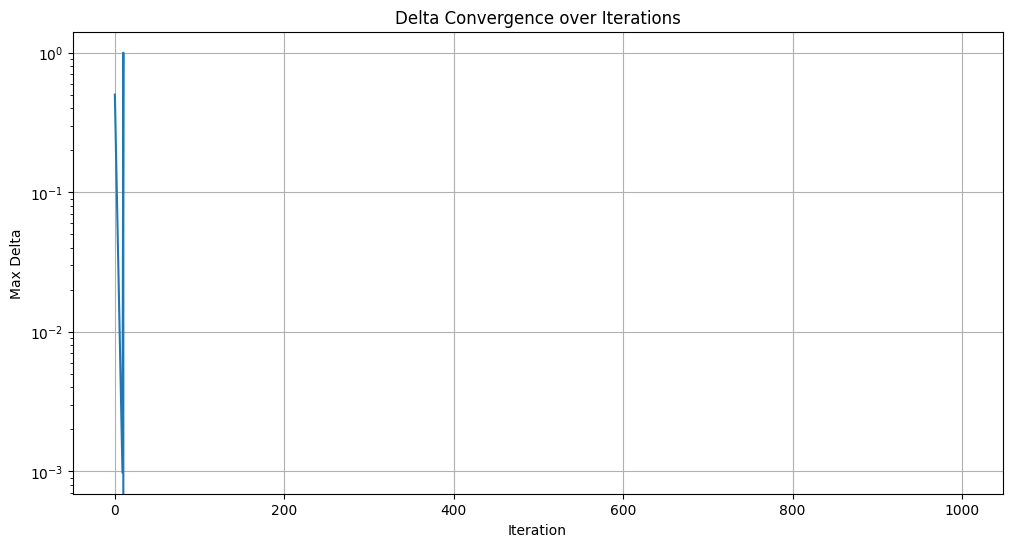

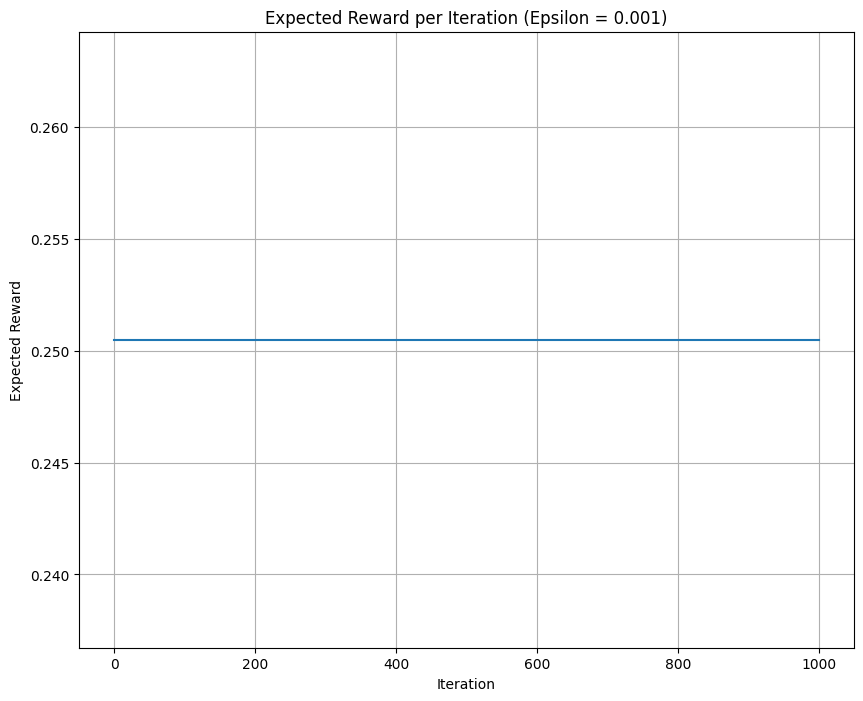

run_value_iteration took 643.2300 seconds to complete.


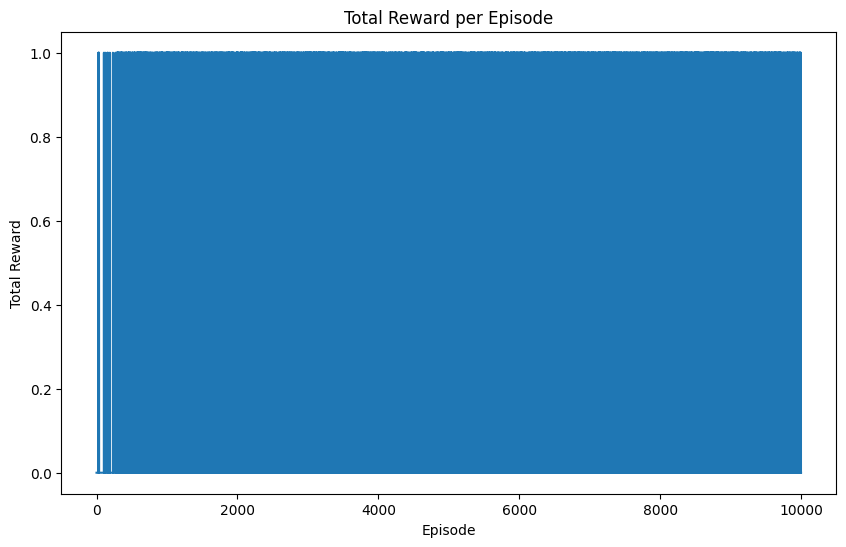

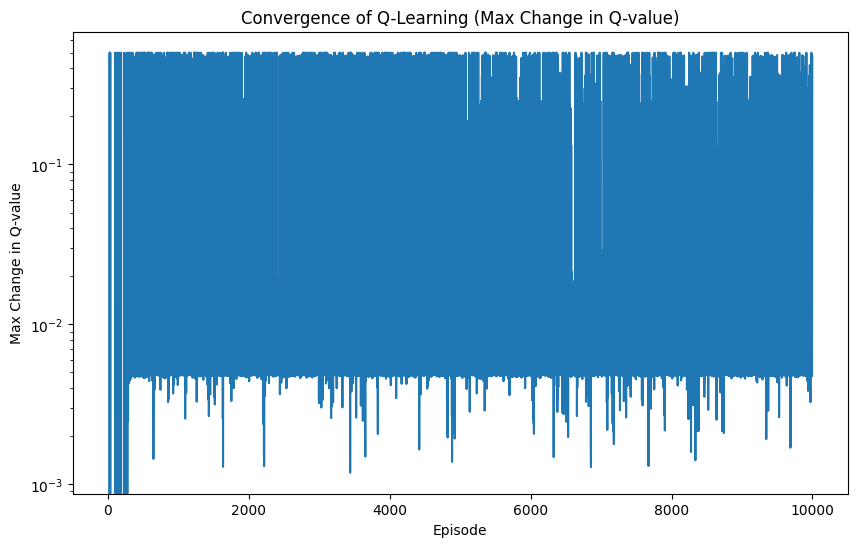

run_q_learning took 40.9723 seconds to complete.


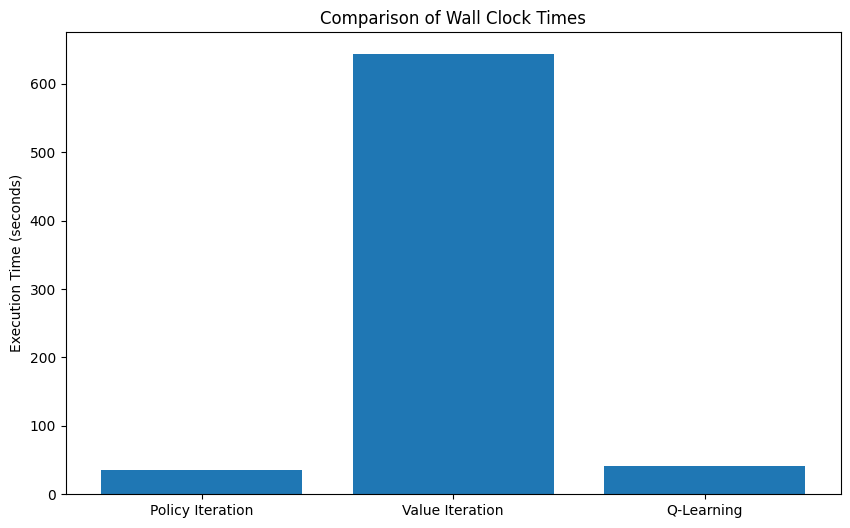

In [9]:
import time

def measure_execution_time(env, algorithm, *args, **kwargs):
    start_time = time.time()
    results = algorithm(env, *args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"{algorithm.__name__} took {execution_time:.4f} seconds to complete.")
    return results, execution_time

# Assuming the environment is already set up
env = GamblersProblemEnv()

# Measure execution time for Policy Iteration
_, pi_time = measure_execution_time(env, run_policy_iteration, gamma_values=[0.9, 0.95, 0.99, 1.0])

# Measure execution time for Value Iteration
_, vi_time = measure_execution_time(env, run_value_iteration, epsilon_values=[0.1, 0.01, 0.001])

# Measure execution time for Q-Learning
_, ql_time = measure_execution_time(env, run_q_learning, episodes=10000, alpha=0.5, gamma=0.99, epsilon=0.1)

# Compare the execution times
plt.figure(figsize=(10, 6))
plt.bar(['Policy Iteration', 'Value Iteration', 'Q-Learning'], [pi_time, vi_time, ql_time])
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Wall Clock Times')
plt.show()
